# I. Apprentissage non-supervisé: Segmentation et visualisation

## I.1 ACP et température de villes de France

On commence par importer les librairies et méthodes nécessaires au déroulement du TP

In [1]:
import numpy as np
np.set_printoptions(threshold=np.nan)
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances

import warnings
warnings.filterwarnings('ignore')

On s'intéresse au fichier 'villes.csv', recençant 32 villes françaises décrites par leur température moyenne pendant chacun des 12 mois de l'année.

In [2]:

data = pd.read_csv('./villes.csv', sep=';') 
X = data.ix[:, 1:13].values
#labels = data.ix[:, 0].values

labels = ["Ajaccio", "Angers", "Angoulème", "Besançon", "Biaritz", "Bordeaux", "Brest", "Clermont-Ferrant", "Dijon", "Embrun", "Grenoble",
       "Lille", "Limoges", "Lyon", "Marseille", "Montélimart", "Nancy", "Nantes", "Nice", "Nîmes", "Orléan", "Paris", "Perpignan", "Reims", "Rennes", 
       "Rouen", "Saint-Quentin", "Strasbourg", "Toulon", "Toulouse", "Tours", "Vichy"]


mois = data.ix[:,0].values
data.head()



Hotel  janv  fev  mars  avril   mai  juin  juil  aout  sept   oct   nov  dec
0  ajac   7.7  8.7  10.5   12.6  15.9  19.8  22.0  22.2  20.3  16.3  11.8  8.7
1  ange   4.2  4.9   7.9   10.4  13.6  17.0  18.7  18.4  16.1  11.7   7.6  4.9
2  ango   4.6  5.4   8.9   11.3  14.5  17.2  19.5  19.4  16.9  12.5   8.1  5.3
3  besa   1.1  2.2   6.4    9.7  13.6  16.9  18.7  18.3  15.5  10.4   5.7  2.0
4  biar   7.6  8.0  10.8   12.0  14.7  17.8  19.7  19.9  18.5  14.8  10.9  8.2

On standardise notre jeu de données, puis on effectue une Analyse en Composantes Principales de celui-ci. Cette analyse consiste à considérer premièrement l'ensemble des attributs comme une base orthonormée d'un espace appelé espace des individus, dans lequel chaque observation est donnée par un point de coordonnées ses valeurs relativement à chaque attribut. En considérant le nuage des n points obtenu à partir des n lignes du tableau de données, on cherche alors une séquence d'axes, appelés axes principaux, qui sont des combinaisons linéaires des vecteurs de base générés par les attributs de départ, de norme 1, orthogonaux deux à deux et rangés par ordre décroissant d'importance, et qui donnent les vecteurs directeurs des droites dans l'espace des individus telles que la donnée projetée sur ces droites admette la plus grande variance possible. 


In [3]:
scaler = StandardScaler().fit(X)

X_nor = scaler.transform(X)

pca = PCA(n_components=0.7, svd_solver='full') 
X_pca = pca.fit_transform(X_nor)

pca.explained_variance_ratio_


array([ 0.87268193])

L'APC retourne un seul axe principal, qui est suffisant pour garder 70 % de la variabilité. Cet axe principal de l'ACP préserve en réalité 87 % de la variance totale du nuage standardisé. On affiche ensuite les 2 premiers axes principaux de l'ACP : 

In [4]:
pca  = PCA(n_components=2)
X_pca = pca.fit_transform(X_nor)

pca.explained_variance_ratio_ 

array([ 0.87268193,  0.11720602])

On constate qu'environ 12 % de la variabilité du nuage de point est expliquée par le second axe. 

On projette ensuite le nuage de points sur le plan généré par les deux premiers axes principaux, et on projette également les 12 attributs de départ pour voir comment ceux-ci sont corrélés aux deux axes principaux (on multiplie la longeur des 12 vecteurs obtenus par 6, par simple soucis de lisibilité):

[ 0.27151028  0.28846164  0.3010811   0.30354174  0.28353089  0.27841907
  0.27290295  0.28757774  0.30472022  0.3038548   0.29242808  0.2729549 ]


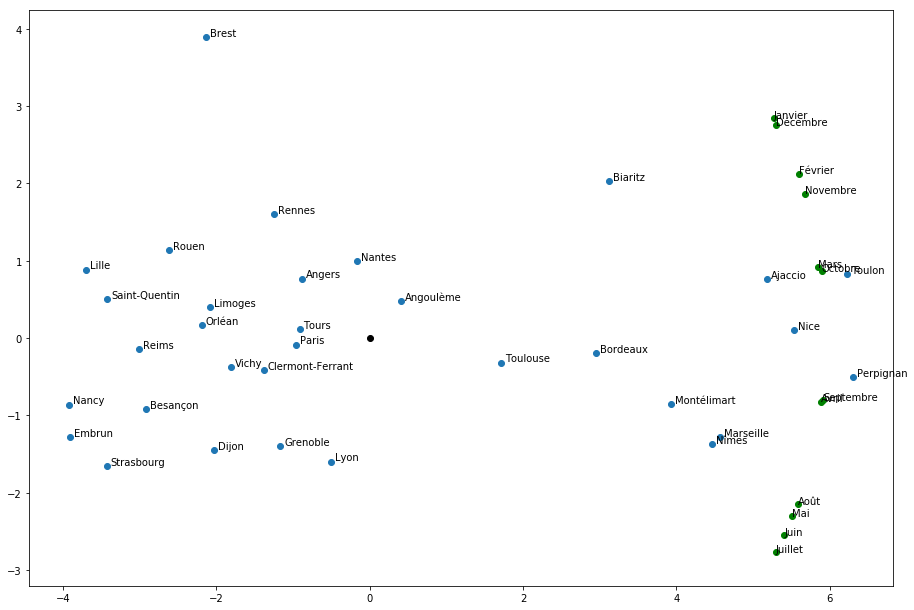

In [5]:
plt.scatter(X_pca[:, 0], X_pca[:, 1])
for label, x, y in zip(labels, X_pca[:, 0], X_pca[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(4, 1), textcoords='offset points')

pc1 = pca.components_[0]  # coordonnées du 1er axe principal dans la base des vecteurs attributs centrés-réduits
pc2 = pca.components_[1]  # coordonnées du second axe principal

print(pc1)

plt.scatter(0,0, color='black')
mois = ["Janvier", "Février", "Mars", "Avril", "Mai", "Juin", "Juillet", "Août", "Septembre", "Octobre", "Novembre", "Décembre"]

for i, mes in enumerate(mois) : # On insere dans le plan principal la projection des vecteurs attiruts de X
    plt.scatter(np.corrcoef(X_pca[:, 0], X[:,i])[0,1]*6, np.corrcoef(X_pca[:, 1], X[:,i])[0,1]*6, color='g')
    plt.annotate(mes,xy= (np.corrcoef(X_pca[:, 0], X[:,i])[0,1]*6, np.corrcoef(X_pca[:, 1], X[:,i])[0,1]*6))

plt.subplots_adjust(bottom=0, top=2, wspace=0.2,left=0, right=2)
plt.show()


On constate que globalement la première composante principale est obtenue comme moyenne des températures pendant les différents mois de l'année, soit la température moyenne annuelle, tandis que la seconde composante principale est corrélée avec les mois frois et anti-corrélée avec les mois chaud : Elle est donc la plus élevée pour les villes avec une grande température en hiver et une petite température en été, ce qui exprime donc cette seconde composante comme une estimation de l'inverse de l'écart de température hiver - été, c'est à dire, plus cet écart dans une ville est faible plus la coordonnée de cette ville dans le second axe principal est élevée.

On constate en particulier que Lyon et Strasbourg sont les villes avec la plus grande variation de température été-hiver.

## I.2 Clustering sur la criminalité aux Etats-Unis

On effectue ici une procédure simialire avec le fichier 'crime.csv' : 

L'ACP nous forunit un seul axe principal pour expliquer 70 % de la variabilité de la donnée (cet axe préserve également 87 % de la variabilité), tandis que le second axe principal explique 8 % de la variabilité, pour un total de 95 % pour ces deux axes. Ces deux "attributs mixtes" expliquent donc très précisément la donnée, et on observe les valeurs de chaque observation dans la base de ces deux axes par une projection orthogonale sur le plan principal. On projette également les attributs de départ (les différents types de crime) afin de constater leur impact respectif sur ces deux axes :

In [6]:
crime = pd.read_csv('./crime.csv', sep=';') # On importe le fichier crime.csv
X = crime.ix[:, 1:8].values # on crée la matrice des valeurs
etats = crime.ix[:, 0].values # on garde la liste des 50 états


scaler = StandardScaler().fit(X)
X_nor = scaler.transform(X)


# première ACP conservant assez d'axes principaux pour expliquer 70 % de variabilité
pca = PCA(n_components=0.7, svd_solver='full') 
X_pca = pca.fit_transform(X)
pca.explained_variance_ratio_ # Retourne un seul axe, qui préserve en réalité 87% de la variance totale du nuage standardisé


# on fait cette fois une ACP à deux axes
pca_2  = PCA(n_components=2) 
X_pca_2 = pca_2.fit(X).transform(X)
pca_2.explained_variance_ratio_ # Les deux premiers axes principaux préservent 95% de la variabilité du nuage

array([ 0.8735949 ,  0.08274478])

[  8.64028896e-04   8.77299190e-03   5.69930688e-02   5.91963208e-02
   4.65345725e-01   8.72862627e-01   1.21383953e-01]


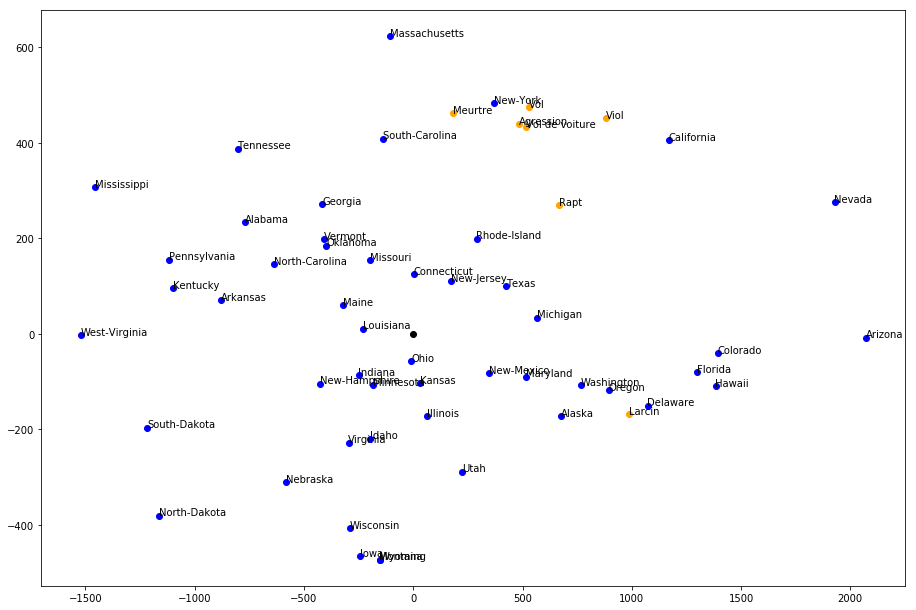

In [7]:
plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], color = 'blue')
for etat, x, y in zip(etats, X_pca_2[:, 0], X_pca_2[:, 1]):
    plt.annotate(etat, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points')
    plt.subplots_adjust(bottom=0, top=1.5, wspace=0.2,left=0, right=1.5)
    
pc1 = pca_2.components_[0]
pc2 = pca_2.components_[1]

print(pc1)

plt.scatter(0,0, color='black')
crimes = ["Meurtre", "Rapt", "Vol", "Agression", "Viol", "Larcin", "Vol de voiture"]

for i, mefait in enumerate(crimes) : 
    plt.scatter(np.corrcoef(X_pca_2[:, 0], X[:,i])[0,1]*1000, np.corrcoef(X_pca_2[:, 1], X[:,i])[0,1]*1000, color='orange')
    plt.annotate(mefait,xy= (np.corrcoef(X_pca_2[:, 0], X[:,i])[0,1]*1000, np.corrcoef(X_pca_2[:, 1], X[:,i])[0,1]*1000))

plt.subplots_adjust(bottom=0, top=2, wspace=0.2,left=0, right=2)
plt.show()

L'interprétation des deux axes principaux est assez floue dans cette situation. La gravité de chaque crime ne semble par exemple pas reliée à ces axes principaux. Ce qui ressort le plus clairement est que le second axe principal est fortement corrélé avec la masse d'attributs 'Meutre', 'Vol', 'Viol', 'Agression', 'Vol de voiture', assez corrélée avec l'attribut 'Rapt' et enfin relativement anti-corrélée avec l'attribut 'Larcin'. 

On souhaite maintenant effectuer différents clusterings de la donnée et de les visualier à l'aide de la projection précédente sur le plan principal.

On effectue un premier clustering selon un partage de la donnée en 3 clusters par la méthode des K-moyennes. Cette méthode sélectionne 3 observations au hasard, et définit 3 clusters selon la méthode du plus proche voisin autour de ces 3 points. Les barycentres des clusters obtenus sont alors calculés, et un nouvel étiquetage par plus proches voisins autour de ces 3 nouveaux centres est effectuée, mettant ainsi à jour le clustering. L'algorithme itère alors ce processus jusqu'à stabilité.

On visualise ensuite le clustering obtenu par projection de l'étiquetage sur le plan principal :

In [8]:
kmeans = KMeans(n_clusters=3) # définition d'une fonction de clustering à 3 clusters
clustering = kmeans.fit_predict(X_nor)

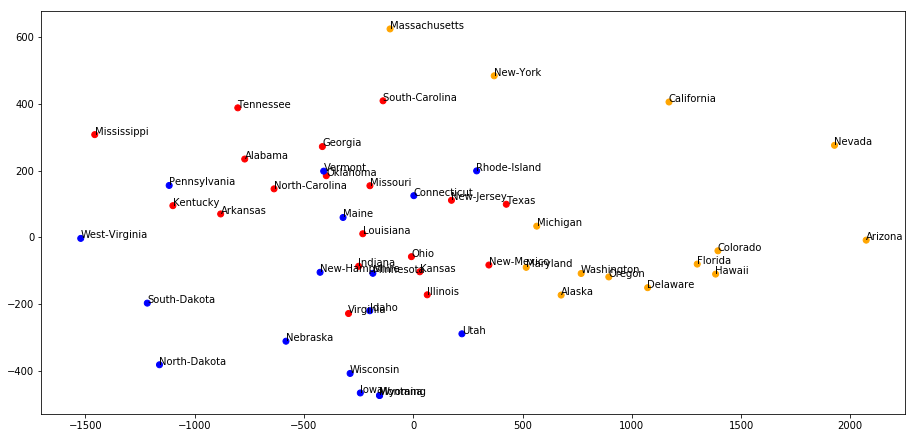

In [9]:
colors = ['red','orange','blue']
plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c= clustering, cmap=matplotlib.colors.ListedColormap(colors))
for etat, x, y in zip(etats, X_pca_2[:, 0], X_pca_2[:, 1]):
 plt.annotate(etat, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points')
 plt.subplots_adjust(bottom=0, top=1.4, wspace=0.2,left=0, right=2)
plt.show()

On effectue maintenant un clustering à 3 clusters selon la méthode de classification ascendante hiérarchique. Cette méthose part des n points d'observation et assemble en un seul cluster deux points choisis, puis assemble successivement deux clusters en minimisant un critère parmis les trois suivants : la variance intra-cluster (option 'ward'), la distance moyenne inter-cluster (option 'average'), la distance maximale inter-cluster (option 'complete'). L'algorithme stoppe au bout de n-3 étapes, ce qui fournit 3 clusters finaux.

On visualise les clustering obtenus en projettant la donnée sur le plan principal :

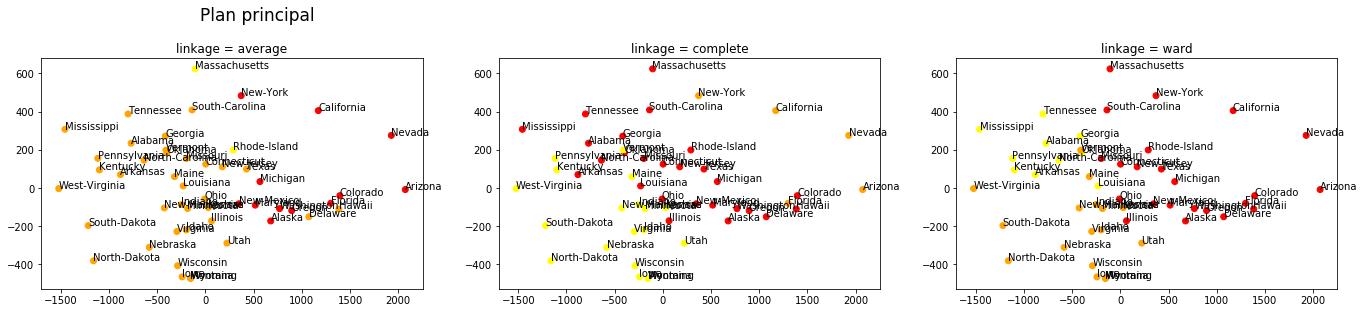

In [10]:
# Clustering Agglomératif pour les trois méthodes d'agglomérats

for index, linkage in enumerate(('average', 'complete', 'ward')):
            plt.subplot(1, 3, index + 1)
            model = AgglomerativeClustering(n_clusters=3, linkage = linkage)            
            colors = ['red','orange','yellow']
            cluster = model.fit_predict(X_nor)
            plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c= cluster, cmap=matplotlib.colors.ListedColormap(colors))
            
            for etat, x, y in zip(etats, X_pca_2[:, 0], X_pca_2[:, 1]):
             plt.annotate(etat, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points')
            
            plt.title('linkage = '+ linkage)


            plt.subplots_adjust(bottom=0, top=.8, wspace=0.2,
                                left=0, right=3)
            plt.suptitle('Plan principal', size=17)


plt.show()

Les trois méthodes fournissent des résultats clairement différents. On donne les trois clustering dans une représentation chacun pour plus de lisibilité, en commencant par la méthode 'ward' seule : 

In [11]:
agglo = AgglomerativeClustering(n_clusters=3, linkage='ward') # définition d'une fonction de clustering à 3 clusters
clustering2 = agglo.fit_predict(X_nor)

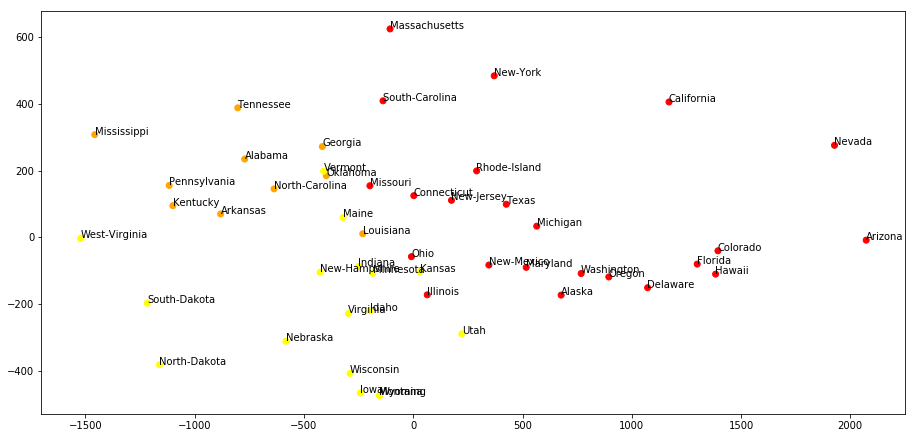

In [12]:
colors = ['red','yellow','orange']
plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c= clustering2, cmap=matplotlib.colors.ListedColormap(colors))
for etat, x, y in zip(etats, X_pca_2[:, 0], X_pca_2[:, 1]):
    plt.annotate(etat, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points')
    plt.subplots_adjust(bottom=0, top=1.4, wspace=0.2,left=0, right=2)

plt.show()

Clustering agglomératif pour méthode 'average' seule :

In [13]:
agglo2 = AgglomerativeClustering(n_clusters=3, linkage='average') # définition d'une fonction de clustering à 3 clusters
clustering22 = agglo2.fit_predict(X_nor)

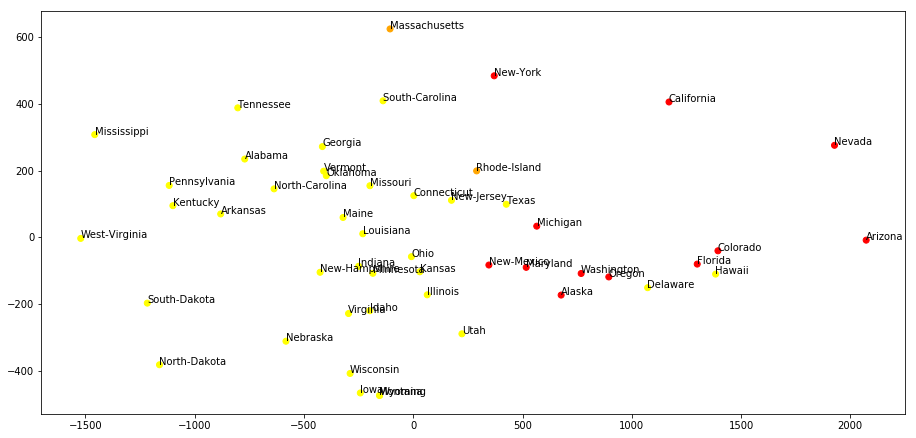

In [14]:
colors = ['red','yellow','orange']
plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c= clustering22, cmap=matplotlib.colors.ListedColormap(colors))
for etat, x, y in zip(etats, X_pca_2[:, 0], X_pca_2[:, 1]):
 plt.annotate(etat, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points')
 plt.subplots_adjust(bottom=0, top=1.4, wspace=0.2,left=0, right=2)
plt.show()

Clustering agglomératif pour méthode 'complete' seule :

In [15]:
agglo3 = AgglomerativeClustering(n_clusters=3, linkage='complete') # définition d'une fonction de clustering à 3 clusters
clustering23 = agglo3.fit_predict(X_nor)

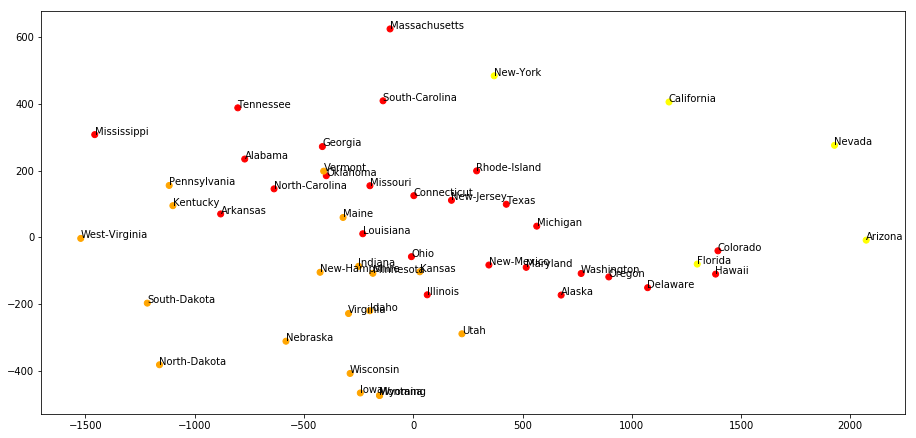

In [16]:
colors = ['red','yellow','orange']
plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c= clustering23, cmap=matplotlib.colors.ListedColormap(colors))
for etat, x, y in zip(etats, X_pca_2[:, 0], X_pca_2[:, 1]):
 plt.annotate(etat, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points')
 plt.subplots_adjust(bottom=0, top=1.4, wspace=0.2,left=0, right=2)
plt.show()

On cherche maintenant, plutôt que de forcer le nombre de clusters comme étant égal à trois, à calibrer le nombre de clusters qui partitionne le plus naturellement la donnée (selon la méthode des K-moyennes) :

In [17]:
def dunn(c, distances):
    """
    Dunn index for cluster validation (the bigger, the better) 
    """
    unique_cluster_distances = np.unique(min_cluster_distances(c, distances))
    max_diameter = max(diameter(c, distances))

    if np.size(unique_cluster_distances) > 1:
        return unique_cluster_distances[1] / max_diameter
    else:
        return unique_cluster_distances[0] / max_diameter

def min_cluster_distances(c, distances):
    """Calculates the distances between the two nearest points of each cluster"""
    min_distances = np.zeros((max(c) + 1, max(c) + 1))
    for i in np.arange(0, len(c)):
        if c[i] == -1: continue
        for ii in np.arange(i + 1, len(c)):
            if c[ii] == -1: continue
            if c[i] != c[ii] and distances[i, ii] > min_distances[c[i], c[ii]]:
                min_distances[c[i], c[ii]] = min_distances[c[ii], c[i]] = distances[i, ii]
    return min_distances

def diameter(c, distances):
    """Calculates cluster diameters (the distance between the two farthest data points in a cluster)"""
    diameters = np.zeros(max(c) + 1)
    for i in np.arange(0, len(c)):
        if c[i] == -1: continue
        for ii in np.arange(i + 1, len(c)):
            if c[ii] == -1: continue
            if c[i] != -1 or c[ii] != -1 and c[i] == c[ii] and distances[i, ii] > diameters[c[i]]:
                diameters[c[i]] = distances[i, ii]
    return diameters 

On compare la qualité des clustering à 2, 3, 4 et 5 classes selon les critères 'dunn' et 'silhouette' :

In [18]:
for i in np.arange(2, 6):
    clustering = KMeans(n_clusters=i).fit_predict(X_nor)
    print("dunn : ", dunn(clustering, euclidean_distances(X_nor, X_nor)), ", silhouette : ", silhouette_score(X_nor, clustering,metric='euclidean'))
print()

dunn :  3.33498256682 , silhouette :  0.320605950817
dunn :  2.29984374641 , silhouette :  0.247291226302
dunn :  1.9283158478 , silhouette :  0.276444750819
dunn :  0.835606020439 , silhouette :  0.283169208793



On constate que le clustering à 2 classes est, pour ces deux critères, le plus pertinent. On affiche ce clustering (avec méthode des K-moyennes) :

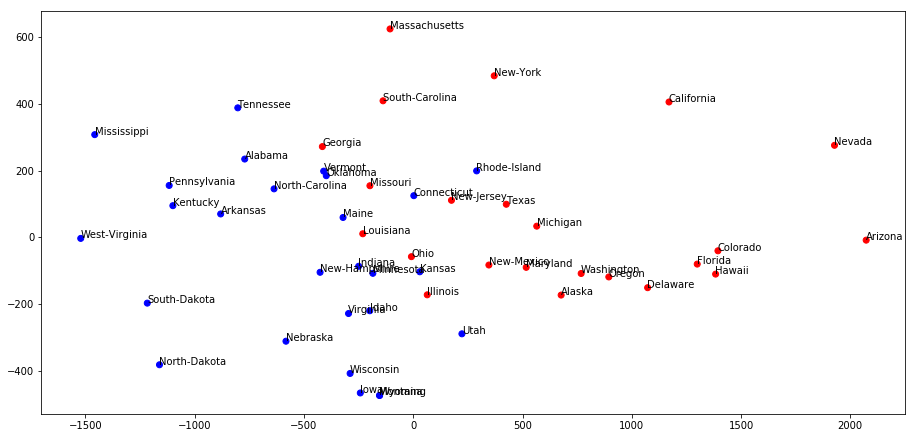

In [19]:
kmeans = KMeans(n_clusters=2) # définition d'une fonction de clustering à 3 clusters
clustering = kmeans.fit_predict(X_nor)


colors = ['red','blue']
plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c= clustering, cmap=matplotlib.colors.ListedColormap(colors))
for etat, x, y in zip(etats, X_pca_2[:, 0], X_pca_2[:, 1]):
 plt.annotate(etat, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points')
 plt.subplots_adjust(bottom=0, top=1.4, wspace=0.2,left=0, right=2)
plt.show()

On constate que, très grossièrement, le clustering à 2 classes départage le nuage de points selon que la coordonnée de chaque point dans la direction du premier axe princiapl soit positive ou négative.

# II. Apprentissage Supervisé: Traitement des attributs et classification

On commence par importer les données à traiter. On a deux possibilités pour traiter les variables qualitatives et les observations avec valeurs manquantes : soit on effectue tous les traitements dans le fichier panda, soit une fois mise en numpy array. On propose brièvement ici la première méthode, et on continue avec la seconde méthode de manière approfondie.

In [20]:
noms = ["V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","Class"]
data = pd.read_csv('./credit.data', sep='\t', names = noms, na_values="?") 
data.head()
print("data.shape : ", data.shape)
# Où sont les NAs ?
print("Nombre de NAs par colonne :\n", data.isnull().sum())
print("Pas beacoup par rapport au nombre d'observations. On peut donc toutes les enlever. ")
data.dropna(inplace=True)
# Pour vérifier
print("NAs maintenant ?\n", data.isnull().any().any())
print("data.shape maintenant :", data.shape)

data.shape :  (688, 16)
Nombre de NAs par colonne :
 V1       12
V2       12
V3        0
V4        5
V5        5
V6        8
V7        8
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14      11
V15       0
Class     0
dtype: int64
Pas beacoup par rapport au nombre d'observations. On peut donc toutes les enlever. 
NAs maintenant ?
 False
data.shape maintenant : (653, 16)


In [21]:
## On transforme les variables qualitatives en "dummies"
data_clean = pd.get_dummies(data, drop_first=True)
X = data_clean
X.shape

(653, 38)

### II.1 Traitement des données numériques sans valeurs manquantes

A partir d'ici on revient à la donnée initiale et on suit la démarche de l'énoncé. 

On effectue un premier nettoyage de la donnée en ne conservant que les attributs quantitatifs et en ôtant les observations contenant des valeurs manquantes.

In [22]:
noms = ["V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","Class"]
data = pd.read_csv('./credit.data', sep='\t', names = noms) 
data.head()

V1     V2     V3 V4 V5 V6 V7    V8 V9 V10  V11 V12 V13  V14  V15 Class
0  b  30.83  0.000  u  g  w  v  1.25  t   t    1   f   g  202    0     +
1  a  58.67  4.460  u  g  q  h  3.04  t   t    6   f   g   43  560     +
2  a  24.50  0.500  u  g  q  h  1.50  t   f    0   f   g  280  824     +
3  b  27.83  1.540  u  g  w  v  3.75  t   t    5   t   g  100    3     +
4  b  20.17  5.625  u  g  w  v  1.71  t   f    0   f   s  120    0     +

In [23]:
X = data.ix[:, 0:16].values
X_entree = X[:, 0:15]
Y = X[:, 15]

# suppression des observations avec valeurs manquantes et filtrage des attributs quantitatifs seuls 

col_num = [1, 2, 7, 10, 13, 14]

X_num = np.copy(X_entree[:, col_num])
X_num[X_num == '?'] = np.nan
X_num = X_num.astype(float)
 
        
index = []
for i, row in enumerate(X_num) :
    ajout = True
    for j in range(6) :
        if np.isnan(row[j]) == True :
            ajout = False
    if ajout == True :
        index.append(i)

X_clean = np.copy(X_num[ index, :])

print(X_clean.shape)

(666, 6)


On transforme la variable de sortie en des modalités 0 - 1, et on affiche le nombre d'occurences pour chaque modalité dans un histogramme :

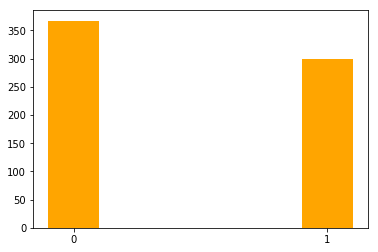

367

In [24]:
#Remplacement des + - par 1 et 0 dans la sortie Y
Y_liste = []
for el in list(Y) :
    if '+' in el :
        Y_liste.append(1)        
    else :
        Y_liste.append(0)
        
Y_clean = np.asarray(Y_liste)[ index ]

plt.figure()
plt.bar(range(2), np.bincount(Y_clean), color = 'orange', width = 0.2)
plt.xticks(range(2), ["0", "1"])
plt.show()
(Y_clean == 0).sum()

On commence avec un simple arbre de décision CART :

In [25]:
from sklearn import tree
import os
os.environ["PATH"] += os.pathsep + 'C:\\ProgramData\\Anaconda3\\Lib\\site-packages\\graphviz'

arbre = tree.DecisionTreeClassifier()
classifieur = arbre.fit(X_clean, Y_clean)


from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(classifieur, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  


#import graphviz 
#dot_data = tree.export_graphviz(classifieur, out_file=None) 
#graph = graphviz.Source(dot_data) 
#graph.render() 

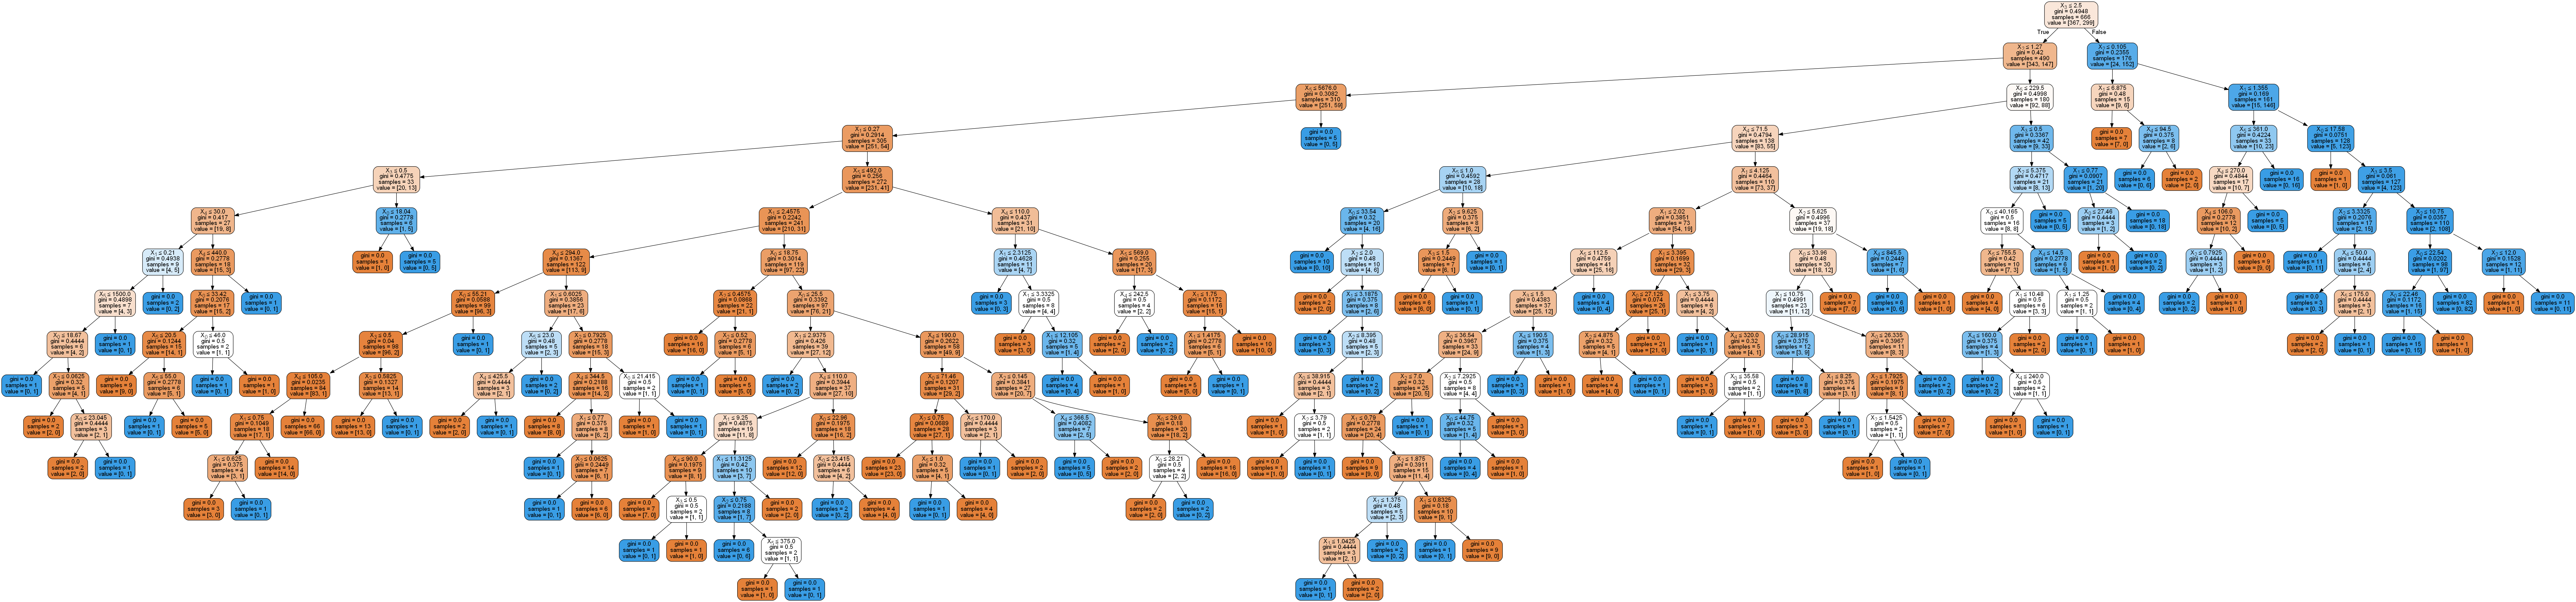

In [26]:
Image(graph.create_png())

On liste l'ensembles des algorithmes que l'on considère ici :

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# from id3 import Id3Estimator

Liste = {
'Naive_Bayes_Gaussien': GaussianNB(),  # Naive Bayes classifier http://scikit-learn.org/stable/modules/naive_bayes.html
'CART': DecisionTreeClassifier(), # Classification And Regression Tree (CART) http://scikit-learn.org/stable/modules/tree.html
#'ID3' : id3.Id3Estimator(gain_ratio= True, prune = True),    # Iterative dichotomizer 3 (ID3) https://pypi.python.org/pypi/decision-tree-id3/0.1.2
'Decision Stump' : DecisionTreeClassifier(max_depth=1), # Decision Stump
'Reseau Neuronal 1 couche cachée': MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20), random_state=1),
'Reseau_Neuronal 2 couches cachées': MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20, 5), random_state=1), # Réseau de neurones à 2 couches cachées http://scikit-learn.org/stable/modules/neural_networks_supervised.html
'Bagging': BaggingClassifier(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=1, random_state=None, verbose=0), # Bootstrap Aggregation http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
'AdaBoost 10': AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=10),
'AdaBoost 50': AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=50), # Adaboost http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html
'KNN 4': KNeighborsClassifier(n_neighbors=4),
'KNN 10': KNeighborsClassifier(n_neighbors=10), # K-plus proches voisins http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
'Forêt_Aléatoire 15 arbres': RandomForestClassifier(n_estimators=15),
'Forêt_Aléatoire 50 arbres': RandomForestClassifier(n_estimators=50)   # Foret aléatoire http://scikit-learn.org/stable/modules/ensemble.html
}

On cherche à comparer les classifieurs obtenus à partir des différents algorithmes selon plusieurs critères : le taux de bien classés, l'AUC (l'aire sous la courbe ROC), la précision / rappel. Pour cela on ne mesure pas ces quantités directement sur chaque classifieur, mais une estimation par validation croisée 10-fold : Cele signifie que, étant donné un algorithme A, on découpe notre échantillon d'apprentissage en 10 partie de tailles similaires et on construit 10 classifieurs via A, chacun étant construit en mettant 1/10ième de l'échantillon de côté. On calcule alors les taux de réussite, l'AUC et la précision / rappel de ces 10 classifieurs sur le 1/10ième restant respectif, et les moyennes de chaque critère sur les 10 classifieurs constituent l'estimation par validation croisée de ces trois quantités sur le classifieur issus de A au départ.   

Pour le choix entre précision et rappel dans notre contexte, on fait l'observation suivante: La réponse 'théorique' d'une personne (c'est à dire, le Y d'une observation du fichier) est la capacité de cette personne à rembourser un éventuel empreint banquaire ('+' si cette personne en est capable, '-' sinon). Un classifieur évalué sur une nouvelle personne donne alors une prédiction sur la capacité qu'a cette personne à rembourser un empreint, et donc l'intérêt qu'aurait la banque à s'intéresser à lui ainsi que le risque qu'il représente.

Ainsi, la **précision** du classifieur déterminera la probabilité qu'un client auquel on a accordé un prêt puisse effectivement rembourser ce prêt (proportion de vrai '+' parmis les '+' prédits), tandis que le **rappel** évalue la probabilité qu'a le classifieur à accorder un crédit à quelqu'un qui peut effectivement le rembourner (proportion de '+' prédits parmis les vrais '+'). Etant donné qu'ici, il est plus dangereux pour la banque d'avoir un client non-solvable que de passer à coté d'un client solvable, on s'intéressera à maximiser la précision plutôt que le rappel dans le choix de classifieur, et c'est cette quantité que l'on cherche donc à évaluer. (si deux classifieurs ont tous deux une précision maximale, on sélectionnera naturellement celui de rappel le plus élevé des deux).


On enrobe cette démarche dans une fonction, qui prend en paramètre la liste des algorithmes à appliquer, ainsi que les données en entrée et en sortie sur lequel les algorithmes se paramétrisent :

In [28]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import roc_auc_score, average_precision_score
import time
%matplotlib inline
from matplotlib.ticker import FuncFormatter
import seaborn as sns

def tracePerformancesPercentage(dictionnaire): 
    pass
    
def runClassifiers(clfs, X, Y, graphe = True) :
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    kf2 = KFold(n_splits=5, shuffle=True, random_state=0)
    
    
    cv_acc = {}
    cv_auc = {}
    cv_prec = {}
    cv_prec5 = {}
    t0 = {}
    t1 = {}
    
    for i in clfs:
        t0[i] = time.time()
        clf = clfs[i] #clf correspond au ième algorithme dans le dictionnaire clfs.
        cv_acc[i] = cross_val_score(clf, X, Y, cv=kf, scoring = 'accuracy' )                       #
        cv_auc[i] = cross_val_score(clf, X, Y, cv=kf, scoring='roc_auc')     # voir http://scikit-learn.org/stable/modules/model_evaluation.html
        cv_prec[i] = cross_val_score(clf, X, Y, cv=kf, scoring='precision')  #
        cv_prec5[i] = cross_val_score(clf, X, Y, cv=kf2, scoring='precision')#
        t1[i] = time.time()
        print("estimations par validation croisée 10 fold de {0} :".format(i))
        print("Taux biens classés = {0:.3f} +/- {1:.3f}".format(np.mean(cv_acc[i]), np.std(cv_acc[i])))
        print("AUC = {0:.3f} +/- {1:.3f}".format(np.mean(cv_auc[i]), np.std(cv_auc[i])))
        print("Précision = {0:.3f} +/- {1:.3f}".format(np.mean(cv_prec[i]), np.std(cv_prec[i])))
        print("Précision (5 fold) = {0:.3f} +/- {1:.3f}".format(np.mean(cv_prec5[i]), np.std(cv_prec5[i])))
        print("Temps d'exécution = {0:.3f} secondes".format(t1[i] - t0[i]))
        print('\n')

    if graphe:
        cv_prec_df = pd.DataFrame.from_dict(cv_prec)
        cv_prec5_df = pd.DataFrame.from_dict(cv_prec5)

        plt.figure(figsize=(30, 8))
        ax1 = plt.subplot(121)
        ax1 = sns.boxplot(data = cv_prec_df, palette="Set3", orient = "h")
        ax1.tick_params(labelsize = 25, colors='darkblue')
        ax1.set_title("Précision par validation croisée 10-folds", fontsize = 30)
        ax2 = plt.subplot(122)
        ax2 = sns.boxplot(data = cv_prec5_df, palette="Set3", orient = "h")
        ax2.set_yticklabels([])
        ax2.tick_params(labelsize = 25, colors='darkblue')
        ax2.set_title("Précision par validation croisée 5-folds", fontsize = 30)
        plt.show()
    

estimations par validation croisée 10 fold de Naive_Bayes_Gaussien :
Taux biens classés = 0.716 +/- 0.050
AUC = 0.793 +/- 0.058
Précision = 0.832 +/- 0.052
Précision (5 fold) = 0.819 +/- 0.026
Temps d'exécution = 0.070 secondes


estimations par validation croisée 10 fold de CART :
Taux biens classés = 0.721 +/- 0.045
AUC = 0.720 +/- 0.048
Précision = 0.687 +/- 0.057
Précision (5 fold) = 0.699 +/- 0.028
Temps d'exécution = 0.132 secondes


estimations par validation croisée 10 fold de Decision Stump :
Taux biens classés = 0.743 +/- 0.064
AUC = 0.723 +/- 0.052
Précision = 0.864 +/- 0.077
Précision (5 fold) = 0.861 +/- 0.064
Temps d'exécution = 0.063 secondes


estimations par validation croisée 10 fold de Reseau Neuronal 1 couche cachée :
Taux biens classés = 0.638 +/- 0.124
AUC = 0.679 +/- 0.130
Précision = 0.615 +/- 0.157
Précision (5 fold) = 0.610 +/- 0.156
Temps d'exécution = 3.541 secondes


estimations par validation croisée 10 fold de Reseau_Neuronal 2 couches cachées :
Taux bien

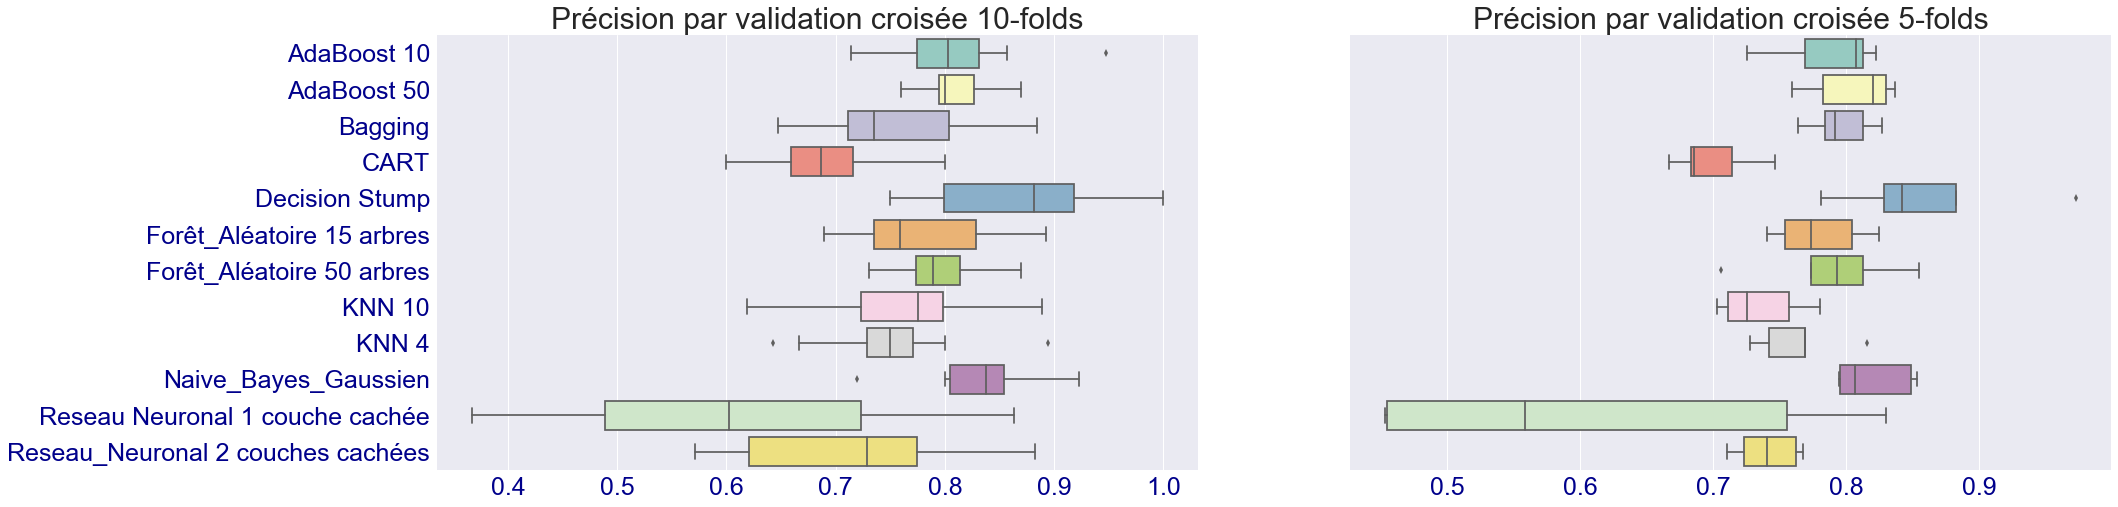

In [29]:
runClassifiers(Liste, X_clean, Y_clean, graphe = True)

**Test des algorithmes**

On teste cette fonction sur nos données :

Les algorithmes offrant les meilleures performances sont le Naive Bayes, la 'souche de décision' / decision stump (de façon surprenante, vu la simplicité de ces deux modèles), Adaboost et Forêts aléatoires (dans les deux cas, spécifier le nombre d'arbres à 50 améliore la qualité). Au contraire, les réseaux de neurones à 1 ou 2 couches cachées (avec 20 neurones sur la première couche cachée) sont relativement peu performantes en comparaison. 

Sur les données standardisées on obtient les scores :

estimations par validation croisée 10 fold de Naive_Bayes_Gaussien :
Taux biens classés = 0.716 +/- 0.050
AUC = 0.793 +/- 0.058
Précision = 0.832 +/- 0.052
Précision (5 fold) = 0.819 +/- 0.026
Temps d'exécution = 0.101 secondes


estimations par validation croisée 10 fold de CART :
Taux biens classés = 0.712 +/- 0.048
AUC = 0.719 +/- 0.051
Précision = 0.687 +/- 0.056
Précision (5 fold) = 0.706 +/- 0.048
Temps d'exécution = 0.170 secondes


estimations par validation croisée 10 fold de Decision Stump :
Taux biens classés = 0.743 +/- 0.064
AUC = 0.723 +/- 0.052
Précision = 0.864 +/- 0.077
Précision (5 fold) = 0.861 +/- 0.064
Temps d'exécution = 0.083 secondes


estimations par validation croisée 10 fold de Reseau Neuronal 1 couche cachée :
Taux biens classés = 0.757 +/- 0.043
AUC = 0.795 +/- 0.052
Précision = 0.739 +/- 0.062
Précision (5 fold) = 0.731 +/- 0.079
Temps d'exécution = 5.823 secondes


estimations par validation croisée 10 fold de Reseau_Neuronal 2 couches cachées :
Taux bien

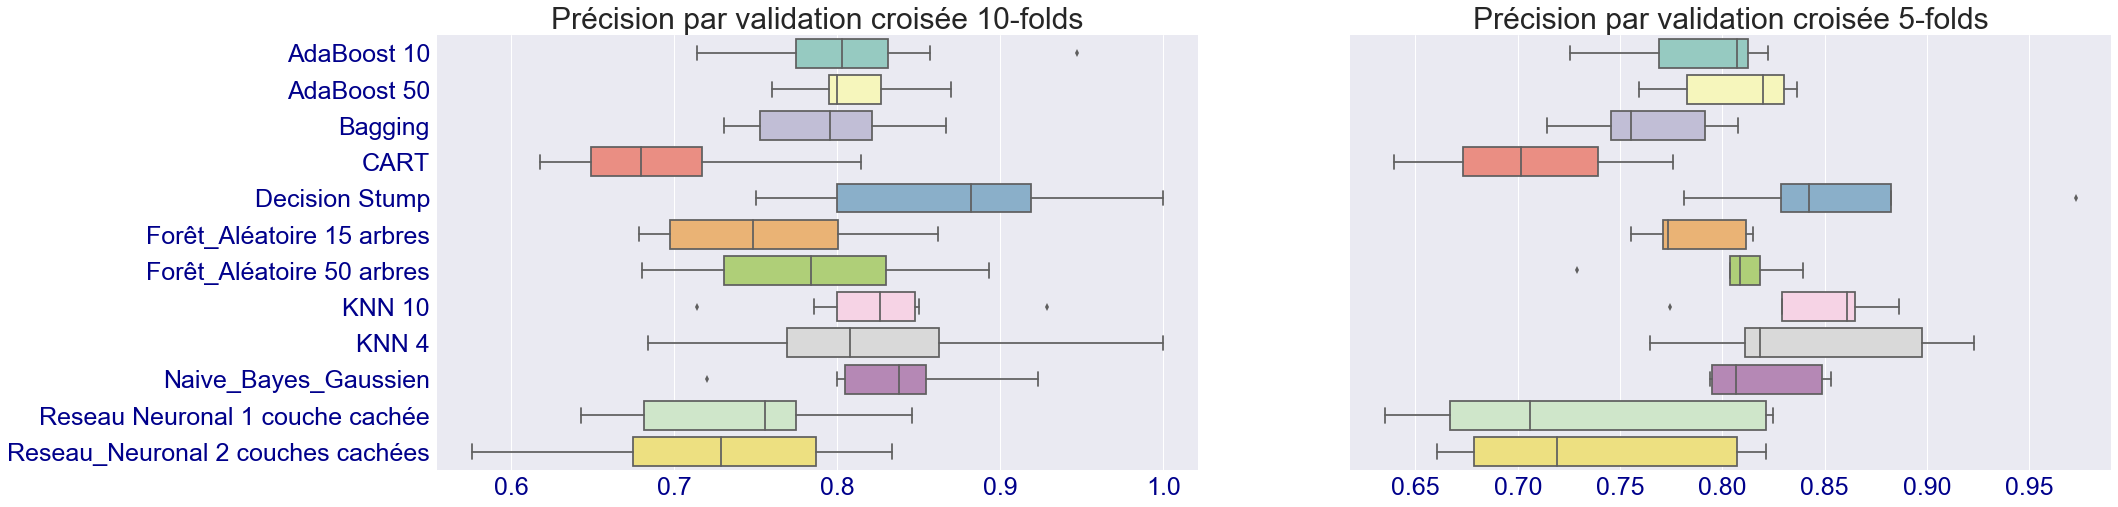

In [30]:
scalerX = StandardScaler().fit(X_clean)
X_std = scalerX.transform(X_clean)


runClassifiers(Liste, X_std, Y_clean)

La standardisation des données améliore sensiblement la performance des deux réseaux de neurones.

Sur les données ramenées à des valeurs entre 0 et 1 par transformation affine sur chaque attribut on obtient :

estimations par validation croisée 10 fold de Naive_Bayes_Gaussien :
Taux biens classés = 0.716 +/- 0.050
AUC = 0.793 +/- 0.058
Précision = 0.832 +/- 0.052
Précision (5 fold) = 0.819 +/- 0.026
Temps d'exécution = 0.109 secondes


estimations par validation croisée 10 fold de CART :
Taux biens classés = 0.718 +/- 0.054
AUC = 0.723 +/- 0.043
Précision = 0.686 +/- 0.045
Précision (5 fold) = 0.700 +/- 0.034
Temps d'exécution = 0.154 secondes


estimations par validation croisée 10 fold de Decision Stump :
Taux biens classés = 0.743 +/- 0.064
AUC = 0.723 +/- 0.052
Précision = 0.864 +/- 0.077
Précision (5 fold) = 0.861 +/- 0.064
Temps d'exécution = 0.069 secondes


estimations par validation croisée 10 fold de Reseau Neuronal 1 couche cachée :
Taux biens classés = 0.757 +/- 0.043
AUC = 0.795 +/- 0.052
Précision = 0.739 +/- 0.062
Précision (5 fold) = 0.731 +/- 0.079
Temps d'exécution = 6.105 secondes


estimations par validation croisée 10 fold de Reseau_Neuronal 2 couches cachées :
Taux bien

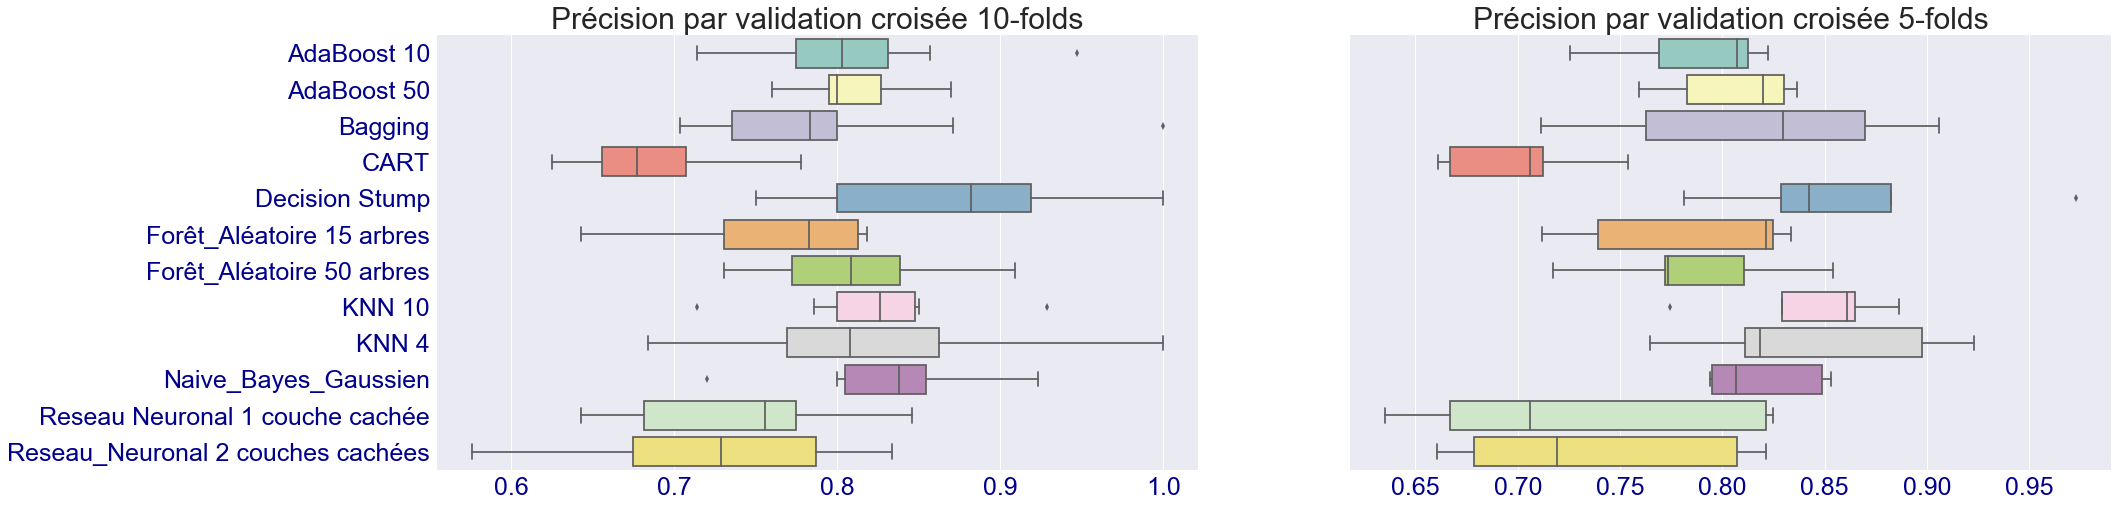

In [31]:
from sklearn.preprocessing import MinMaxScaler

scalerMM = MinMaxScaler().fit(X_clean)
X_MinMax = scalerX.transform(X_clean)


runClassifiers(Liste, X_MinMax, Y_clean)


On extraie les premières composantes principales de la donnée pour pouvoir appliquer nos algorithmes sur cette donnée réduite. On considère ici les 4 premières composantes principales, qui permettent d'atteindre environ 80 % de variabilité de la donnée préservée. On applique alors notre liste d'algorithmes à ces 4 composantes seules :

variance expliquée par les quatre premières composantes principales : 32.30% 17.81% 16.25% 13.24%  


estimations par validation croisée 10 fold de Naive_Bayes_Gaussien :
Taux biens classés = 0.676 +/- 0.055
AUC = 0.765 +/- 0.064
Précision = 0.755 +/- 0.102
Précision (5 fold) = 0.754 +/- 0.069
Temps d'exécution = 0.102 secondes


estimations par validation croisée 10 fold de CART :
Taux biens classés = 0.671 +/- 0.041
AUC = 0.649 +/- 0.047
Précision = 0.629 +/- 0.066
Précision (5 fold) = 0.630 +/- 0.047
Temps d'exécution = 0.181 secondes


estimations par validation croisée 10 fold de Decision Stump :
Taux biens classés = 0.715 +/- 0.058
AUC = 0.716 +/- 0.067
Précision = 0.669 +/- 0.060
Précision (5 fold) = 0.664 +/- 0.043
Temps d'exécution = 0.111 secondes


estimations par validation croisée 10 fold de Reseau Neuronal 1 couche cachée :
Taux biens classés = 0.749 +/- 0.053
AUC = 0.801 +/- 0.036
Précision = 0.756 +/- 0.067
Précision (5 fold) = 0.742 +/- 0.058
Temps d'exécution = 5.913 

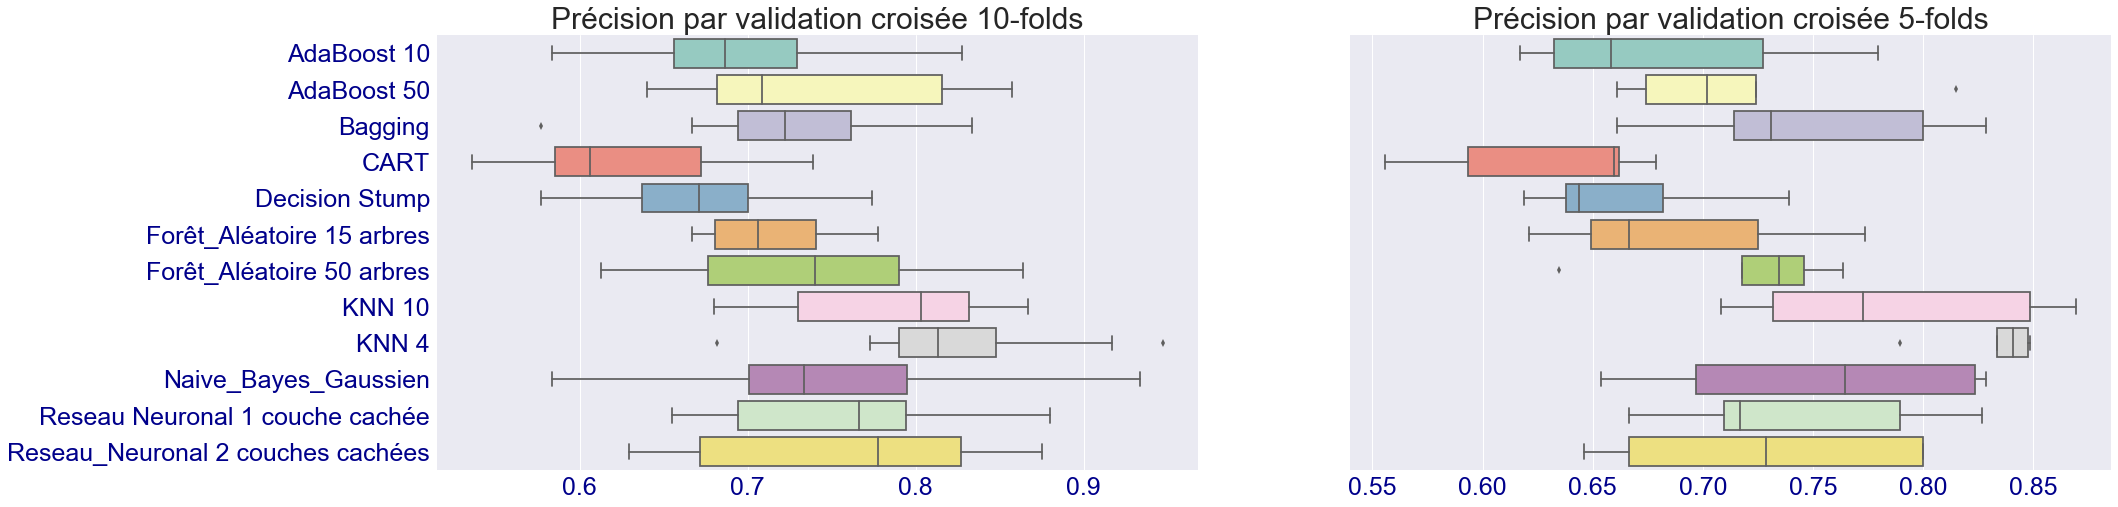

In [32]:
pca = PCA(n_components=0.7, svd_solver='full') 
X_pca = pca.fit(X_std).transform(X_std)

print("variance expliquée par les quatre premières composantes principales : {0:.2f}% {1:.2f}% {2:.2f}% {3:.2f}%  ".format(pca.explained_variance_ratio_[0]*100, pca.explained_variance_ratio_[1]*100, pca.explained_variance_ratio_[2]*100, pca.explained_variance_ratio_[3]*100))

print('\n')
runClassifiers(Liste, X_pca, Y_clean)

Les performances des algorithmes est globalement nettement affaiblie, peut être à l'exeption de la classification par les 4 plus proches voisins. On assemble alors les 4 axes principaux considérés ici à la donnée de départ puis on re-teste la liste d'algorithmes :

estimations par validation croisée 10 fold de Naive_Bayes_Gaussien :
Taux biens classés = 0.710 +/- 0.047
AUC = 0.800 +/- 0.058
Précision = 0.798 +/- 0.057
Précision (5 fold) = 0.786 +/- 0.030
Temps d'exécution = 0.095 secondes


estimations par validation croisée 10 fold de CART :
Taux biens classés = 0.695 +/- 0.060
AUC = 0.704 +/- 0.059
Précision = 0.680 +/- 0.051
Précision (5 fold) = 0.708 +/- 0.053
Temps d'exécution = 0.265 secondes


estimations par validation croisée 10 fold de Decision Stump :
Taux biens classés = 0.743 +/- 0.064
AUC = 0.723 +/- 0.052
Précision = 0.864 +/- 0.077
Précision (5 fold) = 0.861 +/- 0.064
Temps d'exécution = 0.107 secondes


estimations par validation croisée 10 fold de Reseau Neuronal 1 couche cachée :
Taux biens classés = 0.791 +/- 0.064
AUC = 0.827 +/- 0.061
Précision = 0.804 +/- 0.086
Précision (5 fold) = 0.764 +/- 0.028
Temps d'exécution = 5.431 secondes


estimations par validation croisée 10 fold de Reseau_Neuronal 2 couches cachées :
Taux bien

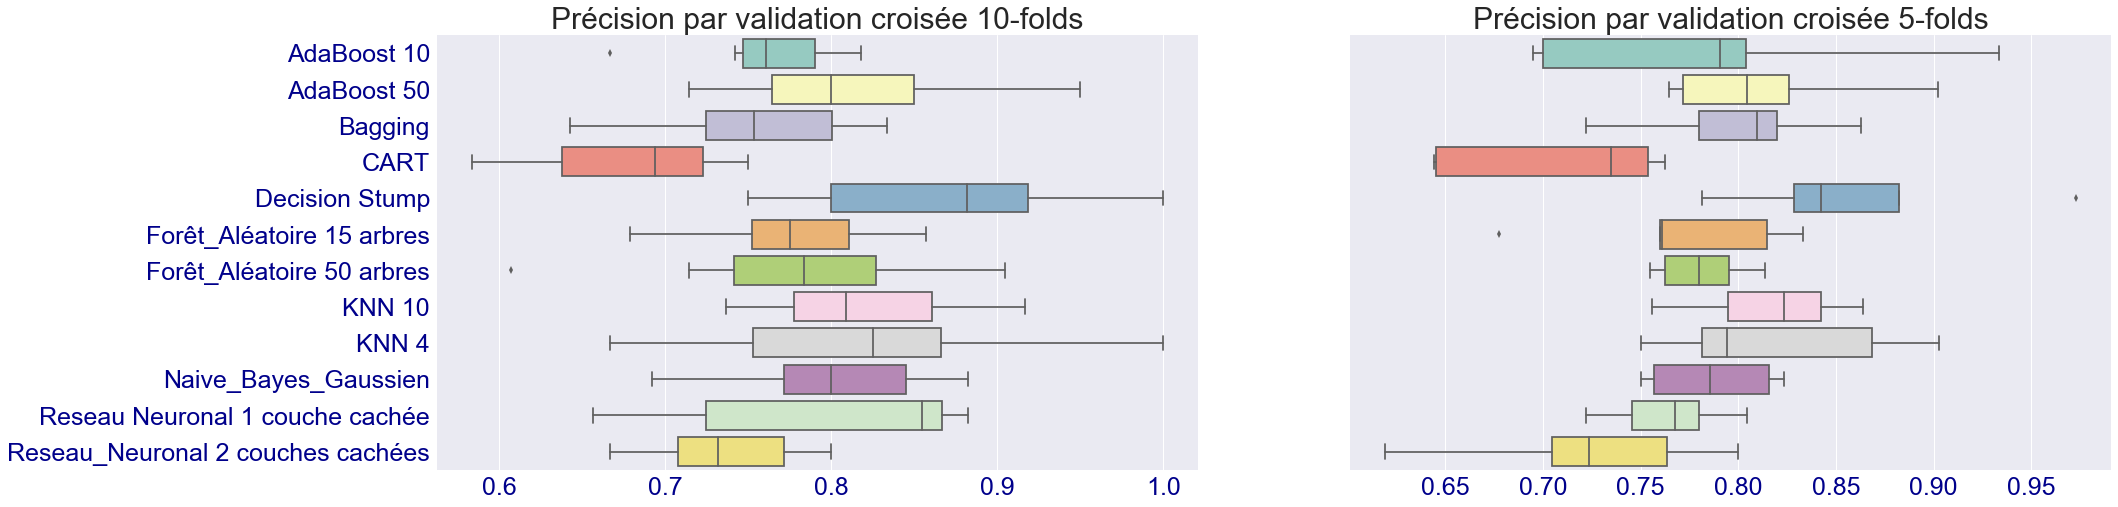

In [33]:
X_merge = np.concatenate((X_std, X_pca[:, :4]), axis = 1)

runClassifiers(Liste, X_merge, Y_clean)

La qualité des classification reste relativement inchangée par rapport à la donnée standardisée seule.

**Sélection de variables par la méthode Random Forest**

On range la liste des variables explicatives dans l'ordre de leur importance selon la méthode random forest. Plusieurs itérations de ce classement montrent que les troisième et quatrième attributs numériques (soient les attributs V8 et V11) sont les plus déterminants :

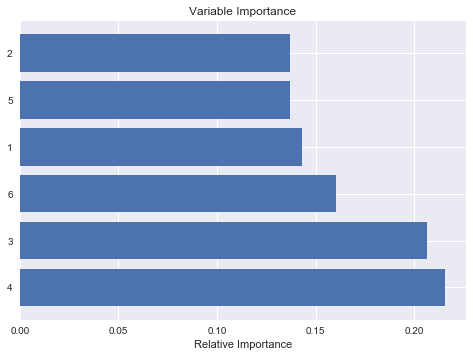

In [34]:
clf = RandomForestClassifier()
clf.fit(X_clean, Y_clean)
importances=clf.feature_importances_

sorted_idx = np.argsort(importances)[::-1]
features = np.arange(1, X_clean.shape[1]+1)
padding = np.arange(X_clean.size/len(X_clean)) + 0.5
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

On se propose de ne garder que les 3ième et 4ième attributs puis de recommencer l'apprentissage sur cette nouvelle donnée. On constate que le résultat des critères de qualités sont sensiblement les mèmes qu'avant :

estimations par validation croisée 10 fold de Naive_Bayes_Gaussien :
Taux biens classés = 0.731 +/- 0.067
AUC = 0.812 +/- 0.068
Précision = 0.863 +/- 0.083
Précision (5 fold) = 0.842 +/- 0.041
Temps d'exécution = 0.085 secondes


estimations par validation croisée 10 fold de CART :
Taux biens classés = 0.725 +/- 0.057
AUC = 0.714 +/- 0.039
Précision = 0.740 +/- 0.057
Précision (5 fold) = 0.730 +/- 0.040
Temps d'exécution = 0.085 secondes


estimations par validation croisée 10 fold de Decision Stump :
Taux biens classés = 0.743 +/- 0.064
AUC = 0.723 +/- 0.052
Précision = 0.864 +/- 0.077
Précision (5 fold) = 0.861 +/- 0.064
Temps d'exécution = 0.069 secondes


estimations par validation croisée 10 fold de Reseau Neuronal 1 couche cachée :
Taux biens classés = 0.758 +/- 0.053
AUC = 0.823 +/- 0.053
Précision = 0.788 +/- 0.042
Précision (5 fold) = 0.778 +/- 0.031
Temps d'exécution = 4.651 secondes


estimations par validation croisée 10 fold de Reseau_Neuronal 2 couches cachées :
Taux bien

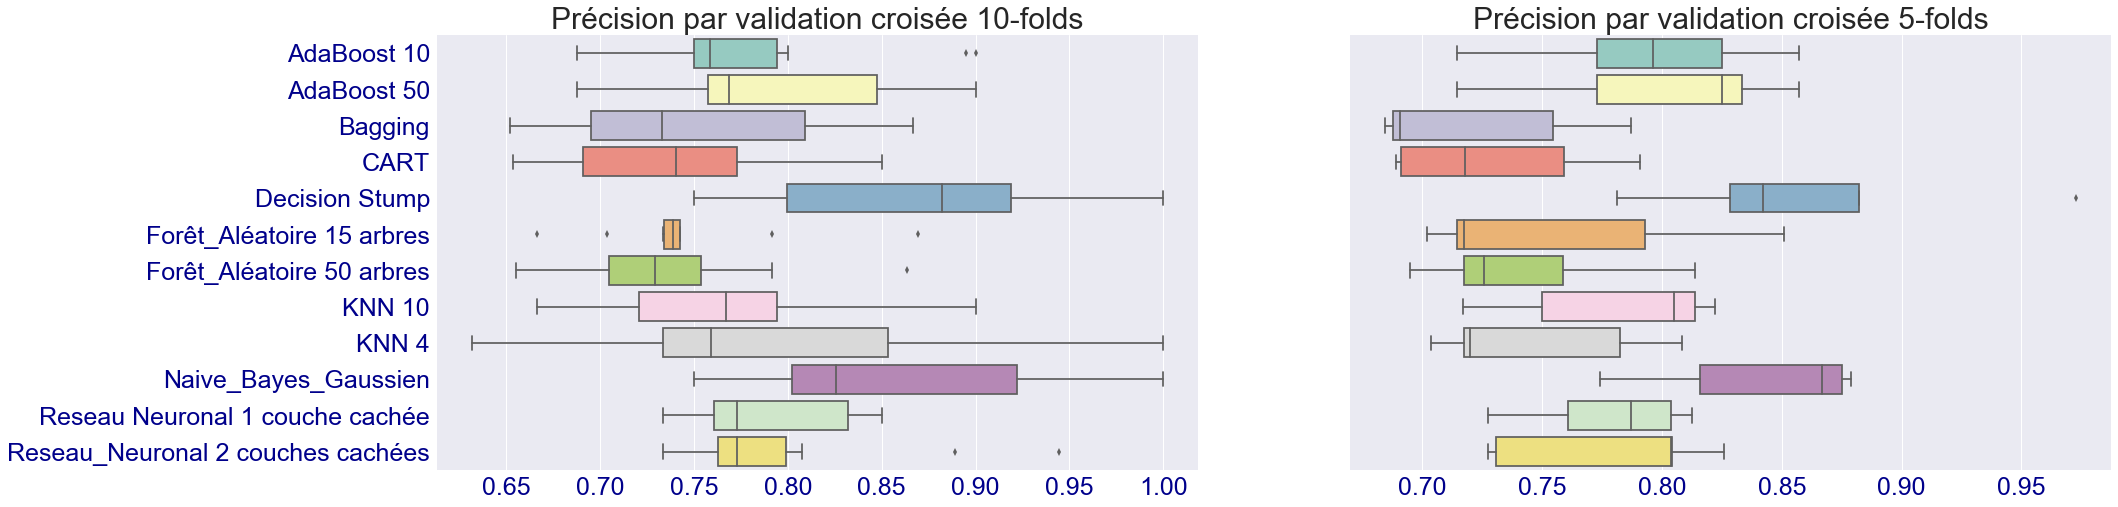

In [35]:
X_34 = np.copy(X_clean[ :, [2, 3]])

runClassifiers(Liste, X_34, Y_clean)

Les résultats restent encore relativement similaires aux résultats sans sélection (il n'y a après tout que peu de variables) sauf les réseaux neuronaux qui sont améliorés.

## II.2 Incorporation des données manquantes

On commence par imputer les valeurs manquantes des variables qualitatives en insérant la valeur la plus fréquente prise par l'attribut correspondant (les deux autres possiblités que propose Imputer sont de remplacer chaque valeur manquante par la moyenne ou la médiale de l'attribut concerné).

In [36]:
from sklearn.preprocessing import Imputer

X_complet = np.copy(X[:, 0:15])
Y_complet = np.copy(X[:, 15])


col_cat = [0, 3, 4, 5, 6, 8, 9, 11, 12]

X_cat = np.copy(X_complet[:, col_cat])
for col_id in range(len(col_cat)):
    unique_val, val_idx = np.unique(X_cat[:, col_id], return_inverse=True)
    X_cat[:, col_id] = val_idx
    print(unique_val)

['?' 'a' 'b']
['?' 'l' 'u' 'y']
['?' 'g' 'gg' 'p']
['?' 'aa' 'c' 'cc' 'd' 'e' 'ff' 'i' 'j' 'k' 'm' 'q' 'r' 'w' 'x']
['?' 'bb' 'dd' 'ff' 'h' 'j' 'n' 'o' 'v' 'z']
['f' 't']
['f' 't']
['f' 't']
['g' 'p' 's']


On constate que seuls les 5 premiers attributs catégoriciels ont des valeurs manquantes, et on impute donc ces valeurs sur ces 5 attributs uniquement. Dans chaque cas la numérisation des entrées met les valeurs manquantes à la valeur 0. C'est donc les occurences de la valeur 0 qu'il faut imputer :

In [37]:
imp_cat = Imputer(missing_values=0, strategy='most_frequent') # or 'mean' or 'median'
X_cat[:, range(5)] = imp_cat.fit_transform(X_cat[:, range(5)])

print(X_cat[: 5])

[[2.0 2.0 1.0 13.0 8.0 1 1 0 0]
 [1.0 2.0 1.0 11.0 4.0 1 1 0 0]
 [1.0 2.0 1.0 11.0 4.0 1 0 0 0]
 [2.0 2.0 1.0 13.0 8.0 1 1 1 0]
 [2.0 2.0 1.0 13.0 8.0 1 0 0 2]]


Puis on complete les données manquantes sur les variables quantitatives, et on génère également la table des composantes principales les plus explicatives :

In [38]:
col_num = [1, 2, 7, 10, 13, 14]

X_num = np.copy(X_complet[:, col_num])
X_num[X_num == '?'] = np.nan
X_num = X_num.astype(float)

imp_num = Imputer(missing_values=np.nan, strategy='mean')
X_num = imp_num.fit_transform(X_num)



# On standardise
scalerX = StandardScaler().fit(X_num)
X_std = scalerX.transform(X_num)

print(X_std[: 5])


# On génère la table des premières composantes principales

pca = PCA(n_components=0.7, svd_solver='full') 
X_pca = pca.fit(X_std).transform(X_std)

print('\n')
print("Variance expliquée par les 4 premières composantes principales : {0} ".format(pca.explained_variance_ratio_))
print('\n')
print(X_pca[: 5])

[[-0.05858175 -0.95795088 -0.29170752 -0.2874895   0.10439271 -0.19553624]
 [ 2.30866796 -0.06198648  0.2429608   0.74053947 -0.81850021 -0.0881273 ]
 [-0.59682495 -0.85750644 -0.21703318 -0.49309529  0.55713263 -0.03749165]
 [-0.31367332 -0.648582    0.45503595  0.53493368 -0.4876518  -0.19496083]
 [-0.96500711  0.17204906 -0.15430672 -0.49309529 -0.37156464 -0.19553624]]


Variance expliquée par les 4 premières composantes principales : [ 0.32171885  0.17719628  0.16416439  0.1317849 ] 


[[-0.8203577  -0.07612307 -0.40821197 -0.06593406]
 [ 1.67312227 -0.41886625 -0.80642931 -0.78145001]
 [-1.16304804  0.30571937 -0.28491631  0.12346382]
 [ 0.13161719 -0.38769942 -0.0802297   0.50806318]
 [-0.59200063 -0.48662529  0.6182064   0.0341961 ]]


On remplace alors chaque variables qualitatives à m modalités par m variables binaires ;

In [39]:
from sklearn.preprocessing import OneHotEncoder
encoder  =  OneHotEncoder()
encoder_fit = encoder.fit_transform(X_cat)
X_cat_bin = encoder_fit.toarray()


print(encoder.n_values_) 
print(encoder.feature_indices_)
print(X_cat_bin.shape)
# 45 modalités au total sur les 9 variables qualitatives
# trois variables étaient déjà binaires
# Pourquoi a-t-on 40 variables et non 42 ou 45 ?


[ 3  4  4 15 10  2  2  2  3]
[ 0  3  7 11 26 36 38 40 42 45]
(688, 40)


On concatène les tableaux de données formés :

In [40]:
print(X_cat_bin.shape)
print(X_std.shape)
print(X_pca.shape)

X_final = np.concatenate((X_cat_bin, X_std, X_pca), axis = 1)

# conversion des + - en 0 1
Y_liste = []
for el in list(Y_complet) :
    if '+' in el :
        Y_liste.append(1)        
    else :
        Y_liste.append(0)
        
Y_final = np.asarray(Y_liste)

print(type(X_final))
print(X_final.shape)
print(len(Y_final))

(688, 40)
(688, 6)
(688, 4)
<class 'numpy.ndarray'>
(688, 50)
688


On affiche enfin un petit histogramme des variables selon leur importance :

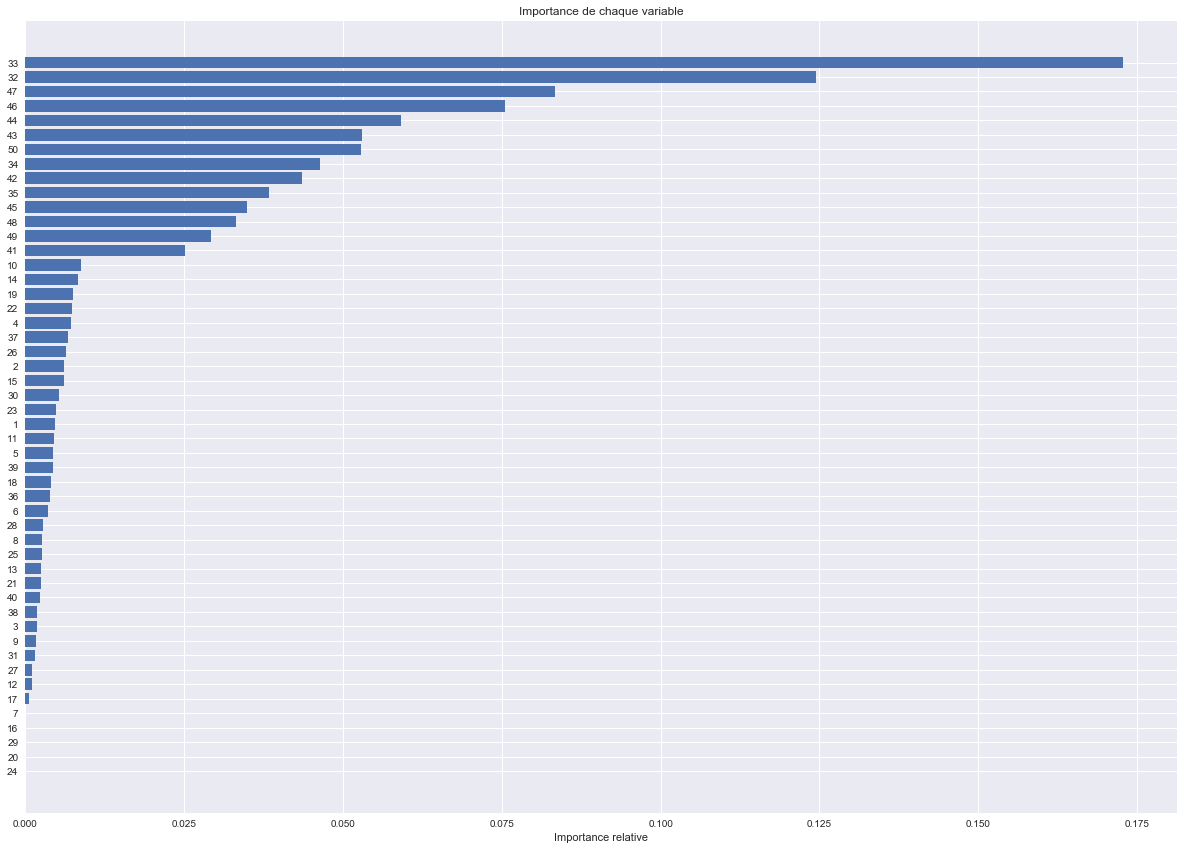

In [41]:
clf = RandomForestClassifier()
clf.fit(X_final, Y_final)
importances=clf.feature_importances_

sorted_idx = np.argsort(importances) # [::-1] pour un ordre inversé
features = np.arange(1, X_final.shape[1]+1)
padding = np.arange(X_final.size/len(X_final)) + 0.5
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Importance relative")
plt.title("Importance de chaque variable")
plt.subplots_adjust(bottom=0, top=2, wspace=0.2,left=0, right=2)
plt.show()

On peut alors tenter de lancer nos algorithmes sur la donnée avec tous les attributs inclus et valeurs manquantes imputées, premièrement sur les variables les plus pertinentes sélectionnées dans l'histogramme précédent, puis sur la donnée totale dans un second temps :

estimations par validation croisée 10 fold de Naive_Bayes_Gaussien :
Taux biens classés = 0.808 +/- 0.046
AUC = 0.896 +/- 0.047
Précision = 0.838 +/- 0.065
Précision (5 fold) = 0.850 +/- 0.045
Temps d'exécution = 0.078 secondes


estimations par validation croisée 10 fold de CART :
Taux biens classés = 0.794 +/- 0.042
AUC = 0.803 +/- 0.039
Précision = 0.770 +/- 0.058
Précision (5 fold) = 0.763 +/- 0.068
Temps d'exécution = 0.258 secondes


estimations par validation croisée 10 fold de Decision Stump :
Taux biens classés = 0.856 +/- 0.044
AUC = 0.866 +/- 0.040
Précision = 0.789 +/- 0.074
Précision (5 fold) = 0.789 +/- 0.056
Temps d'exécution = 0.103 secondes


estimations par validation croisée 10 fold de Reseau Neuronal 1 couche cachée :
Taux biens classés = 0.818 +/- 0.029
AUC = 0.881 +/- 0.039
Précision = 0.809 +/- 0.060
Précision (5 fold) = 0.802 +/- 0.037
Temps d'exécution = 5.791 secondes


estimations par validation croisée 10 fold de Reseau_Neuronal 2 couches cachées :
Taux bien

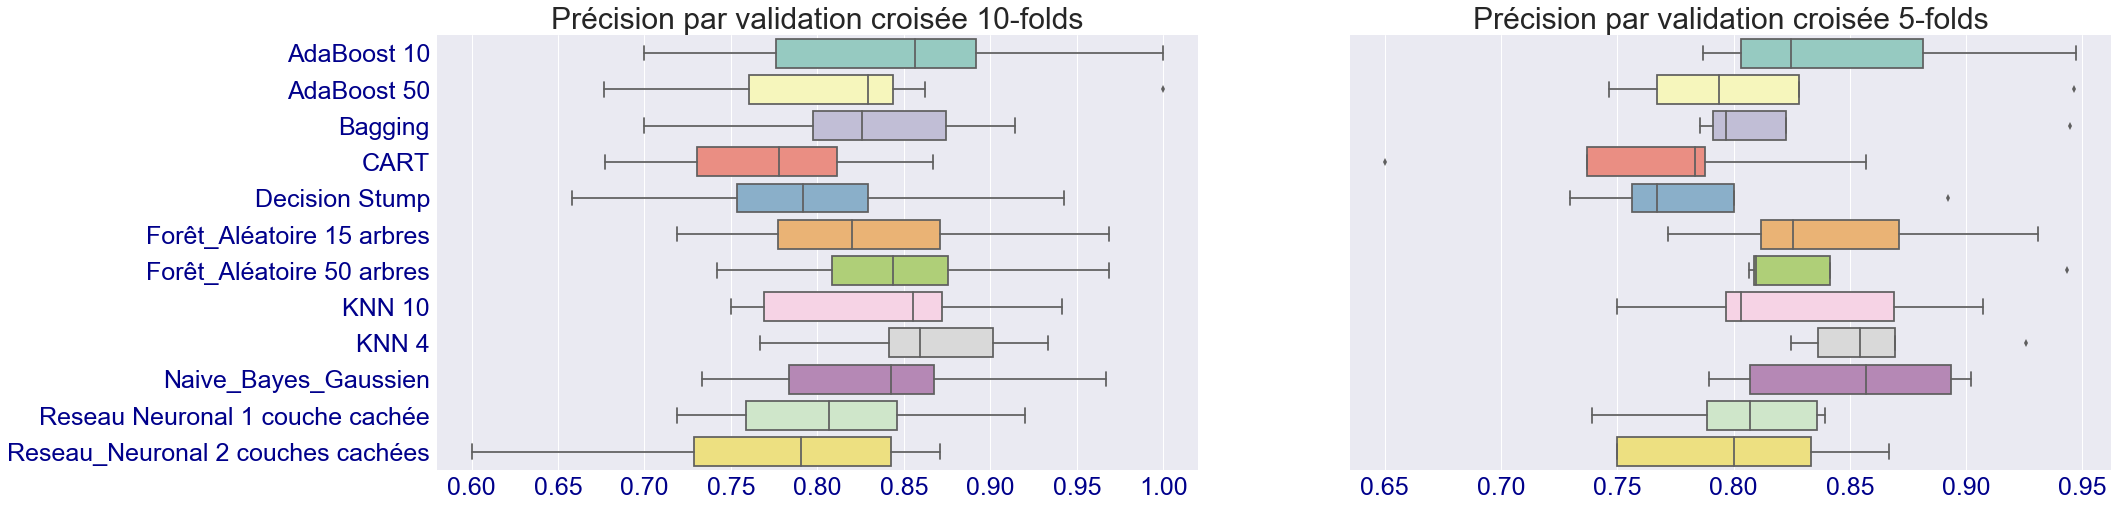

In [42]:
col_principales = [33, 32, 47, 43, 44, 46, 42, 45, 50, 49, 41, 48, 35 ]
col_principales_moins1 = [i -1 for i in col_principales]

X_final_principal = np.copy(X_final[:, col_principales_moins1])

runClassifiers(Liste, X_final_principal, Y_final)

La considération des variables à modalités et l'intégrations des observations incomplètes a sensiblement amélioré chaque algorithme.

On termine par le test de nos algorithmes sur la donnée X_final totale :

estimations par validation croisée 10 fold de Naive_Bayes_Gaussien :
Taux biens classés = 0.725 +/- 0.055
AUC = 0.877 +/- 0.046
Précision = 0.865 +/- 0.104
Précision (5 fold) = 0.862 +/- 0.059
Temps d'exécution = 0.121 secondes


estimations par validation croisée 10 fold de CART :
Taux biens classés = 0.798 +/- 0.053
AUC = 0.806 +/- 0.053
Précision = 0.786 +/- 0.065
Précision (5 fold) = 0.773 +/- 0.059
Temps d'exécution = 0.322 secondes


estimations par validation croisée 10 fold de Decision Stump :
Taux biens classés = 0.856 +/- 0.044
AUC = 0.866 +/- 0.040
Précision = 0.789 +/- 0.074
Précision (5 fold) = 0.789 +/- 0.056
Temps d'exécution = 0.103 secondes


estimations par validation croisée 10 fold de Reseau Neuronal 1 couche cachée :
Taux biens classés = 0.817 +/- 0.034
AUC = 0.864 +/- 0.032
Précision = 0.795 +/- 0.035
Précision (5 fold) = 0.793 +/- 0.034
Temps d'exécution = 3.812 secondes


estimations par validation croisée 10 fold de Reseau_Neuronal 2 couches cachées :
Taux bien

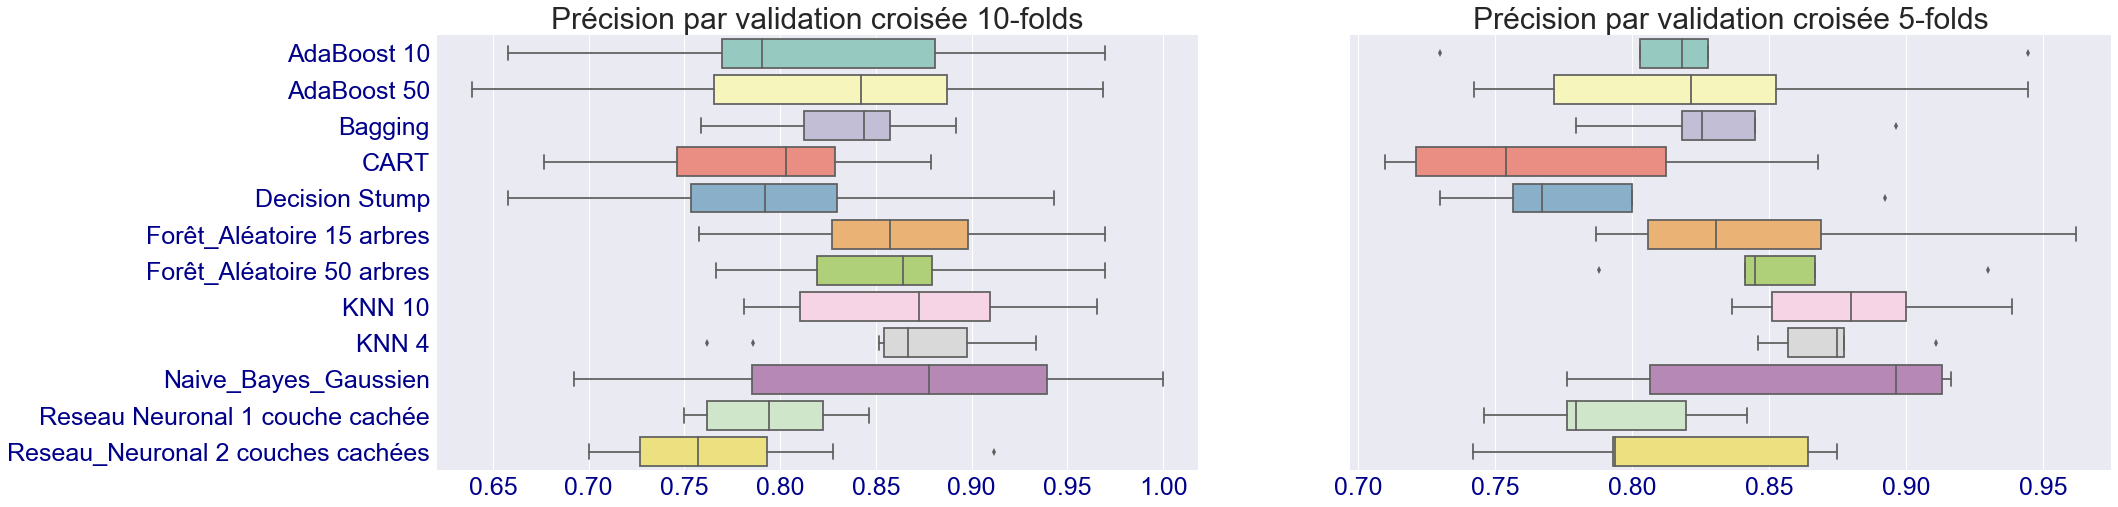

In [43]:
runClassifiers(Liste, X_final, Y_final)

# III. Apprentissage supervisé sur des données textuelles

On charge tout d'abord la liste des SMS avec leur classification Spam/Non-spam :

In [44]:
noms_SMS = ["Nature_SMS","Contenu_SMS"]
data_SMS = pd.read_csv('./SMSSpamCollection.data', sep='\t', header = None ,names = noms_SMS) 
print(data_SMS.head())

X = data_SMS.ix[:, :].values
X_corpus = np.copy(X[:, 1])

Y_class = []
for el in X[:, 0] :
    if el == 'spam' :
        Y_class.append(1)
    elif el == 'ham' :
        Y_class.append(0)
    else :
        print("un SMS n'est pas classé")

#print(Y_class[ : 5])


  Nature_SMS                                        Contenu_SMS
0        ham  Go until jurong point, crazy.. Available only ...
1        ham                      Ok lar... Joking wif u oni...
2       spam  Free entry in 2 a wkly comp to win FA Cup fina...
3        ham  U dun say so early hor... U c already then say...
4        ham  Nah I don't think he goes to usf, he lives aro...


On effectue avant toute chose une petite comparaison entre les quantités de SMS spam et non-spam :

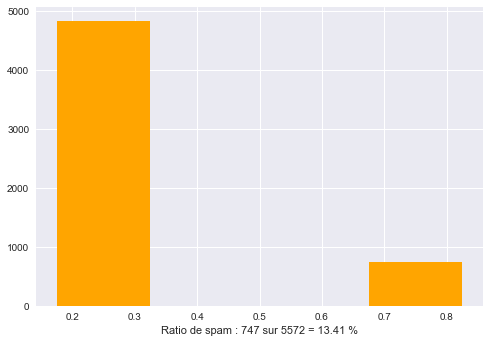

In [45]:
Y_1 = [i for i in Y_class if i ==1]

plt.hist( Y_class, bins= 2, color = 'orange', rwidth = 0.3)
plt.xlabel("Ratio de spam : {0} sur {1} = {2:.2f} %".format(len(Y_1), len(Y_class),len(Y_1)/len(Y_class)*100))
plt.show()

### Vectorisation des SMS par comptage de mots

On vectorise cet ensemble de donnée par la méthode 'sac de mots' : la liste des attributs est donnée par l'ensemble des mots apparaissant dans le corpus de SMS, tandis qu'une observation consiste en un SMS, décrit par le nombre d'occurence de chaque mot dans celui-ci. L'aide se trouve sur http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

La quantité d'information perdue ici est énorme, puisque n'importe quelle permutation dans l'ordre des mots de chaque SMS ne change pas cette représentation. Elle est cependant suffisante pour extraire les co-occurences de mots dans un même SMS (mais pas dans une même phrase). On commence par charger les données en entier :

In [46]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer_fit = vectorizer.fit_transform(X_corpus)
X_vect = vectorizer_fit.toarray()

Vocab = vectorizer.get_feature_names()
print(Vocab[:10])
print(type(X_vect))

['00', '000', '000pes', '008704050406', '0089', '0121', '01223585236', '01223585334', '0125698789', '02']
<class 'numpy.ndarray'>


On ne conserve ici que les 500 mots les plus fréquents dans le corpus :

In [47]:
freq ={}
val_freq = []
for i in range(X_vect.shape[1]) :
    nbre = 0
    for j in range(X_vect.shape[0]) :
        nbre += X_vect[j, i]
    freq[i] = nbre/X_vect.shape[0]
    val_freq.append(nbre/X_vect.shape[0])

limit= sorted(val_freq, reverse = True)[500]

freq_500 = []
for cle, valeur in freq.items() :
    if valeur >= limit :
        freq_500.append(int(cle))
        

In [48]:
X_500 = np.copy(X_vect[:, freq_500[:500]])

X_500.shape

(5572, 500)

On évalue nos différents algorithmes sur ce jeu de donnée, où on s'intérresse là encore au critère de précision plutôt que le rappel : En effet, la précision donne le taux de spams parmis les SMS classés spam, qu'il est très important de maximiser puisque des SMS classés spam par erreur sont une perte importante d'information pour le destinataire de ces SMS. Au contraire, le rappel donne le taux de spam effectivement classés spam, qui pour des valeurs basses n'à comme seule conséquence de laisser passer des spam.

estimations par validation croisée 10 fold de Naive_Bayes_Gaussien :
Taux biens classés = 0.664 +/- 0.018
AUC = 0.789 +/- 0.010
Précision = 0.280 +/- 0.032
Précision (5 fold) = 0.285 +/- 0.030
Temps d'exécution = 5.123 secondes


estimations par validation croisée 10 fold de CART :
Taux biens classés = 0.967 +/- 0.006
AUC = 0.934 +/- 0.011
Précision = 0.884 +/- 0.042
Précision (5 fold) = 0.872 +/- 0.024
Temps d'exécution = 51.761 secondes


estimations par validation croisée 10 fold de Decision Stump :
Taux biens classés = 0.885 +/- 0.009
AUC = 0.697 +/- 0.027
Précision = 0.594 +/- 0.058
Précision (5 fold) = 0.593 +/- 0.052
Temps d'exécution = 3.735 secondes


estimations par validation croisée 10 fold de Reseau Neuronal 1 couche cachée :
Taux biens classés = 0.975 +/- 0.008
AUC = 0.974 +/- 0.012
Précision = 0.909 +/- 0.036
Précision (5 fold) = 0.910 +/- 0.018
Temps d'exécution = 105.257 secondes


estimations par validation croisée 10 fold de Reseau_Neuronal 2 couches cachées :
Taux b

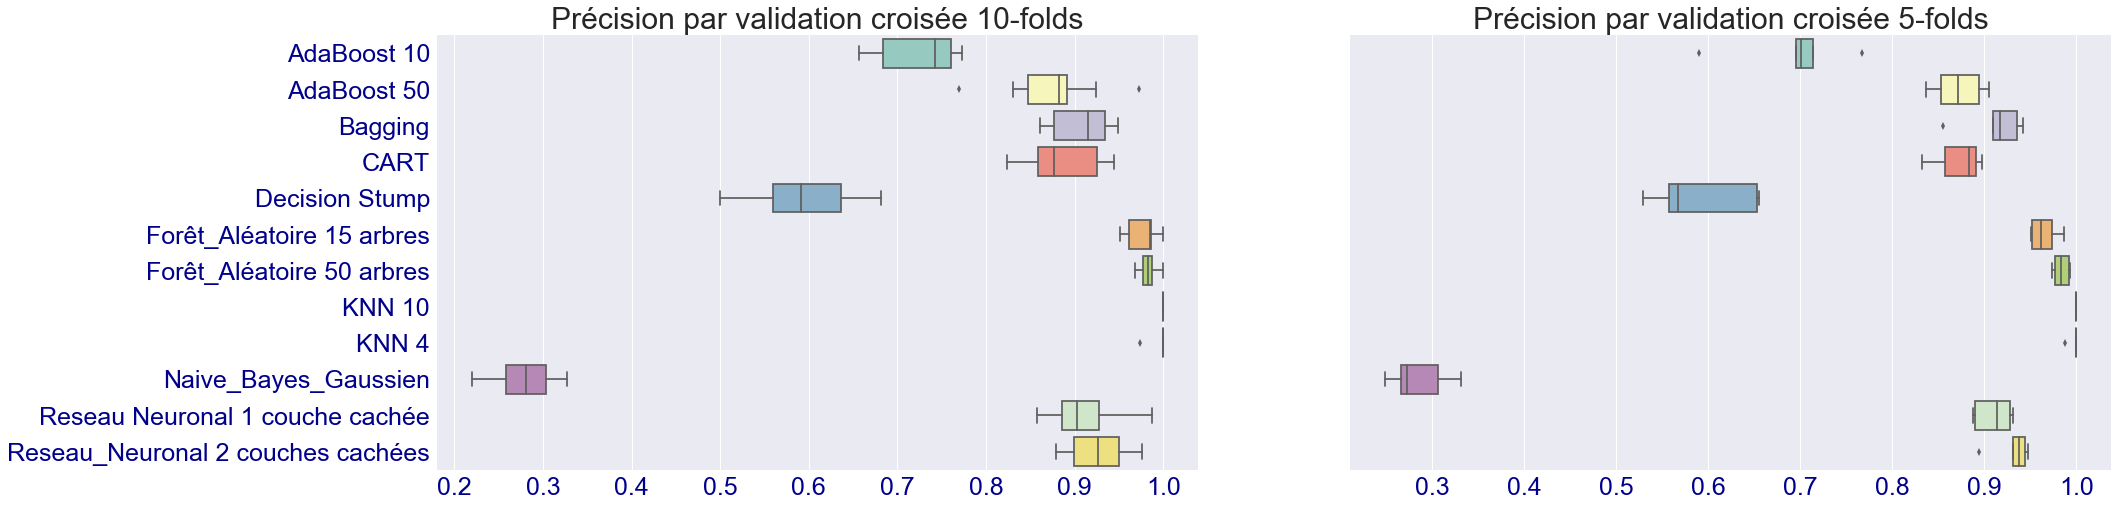

In [49]:
runClassifiers(Liste, X_500, Y_class)

Tous les algorithmes affichent des taux de biens classés proche de 1, à l'exeption du Naive Bayes et de la souche de décision (decision stump). Ces deux algorithme affichent de plus une près faible précision (0.28 et 0.59 par validation croisée 5 fold) et ne sont donc pas en l'état des classifieurs pertinents. Les réseaux de neurones, forêts aléatoires et méthodes à K-plus proches voisins sont les méthodes les plus efficaces, avec une mention spéciale pour les 10 plus proches voisins qui atteint la précision optimale égale à 1 lors de l'estimation par validation croisée (5 fold et 10 fold). Les résultats sont donc de façon gfénérale très satisfaisants.

### Présence / abscence de numéro de téléphone

On s'appercoit que beaucoup de mots du dictionnaire formé sont en réalité des suites de chiffres, que l'on interprete ici comme des numéros de téléphone. On se demande alors si la présence d'un tel numéro dans un SMS est corrélé avec le fait que le SMS soit un spam ou non, et pour regarder ceci on construit un attribut binaire donnant pour chaque SMS la présence ou non d'un tel numéro. Une suite de 6 chiffres pouvant être interprétée comme une date, on ne sélectionne que les 'mots' contenant au moins 7 chiffres. On identifie ainsi 301 'mots' considérés comme des numéros.

In [50]:
Numeros = []
for mot in Vocab :
    d = 0
    for c in mot:
        if c.isdigit():
            d=d+1
    if d > 6 :
        Numeros.append(mot)
        
print(Numeros[:10])
print(len(Numeros))

SMS_avec_num = [ 0 for j in range(X_vect.shape[0])]
for i in range(X_vect.shape[0]) :
    for N in Numeros :
        if N in data_SMS['Contenu_SMS'] :
            SMS_avec_num[i] = 1
            break

            
print(SMS_avec_num[:10]) # les premiers SMS ne contiennement pas de numéro

# On vérifie que la liste de 'contient / ne contient pas de numéro' fait bien la meme taille que la liste de SMS
print(X_vect.shape[0])
print(len(SMS_avec_num))
print(len(Y_class))

['008704050406', '01223585236', '01223585334', '0125698789', '02072069400', '02073162414', '02085076972', '07008009200', '07046744435', '07090201529']
301
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
5572
5572
5572


On fait un petit test pour savoir si la prédiction de spam / non-spam est améliorée en ajoutant ce nouvel attribut :

estimations par validation croisée 10 fold de Naive_Bayes_Gaussien :
Taux biens classés = 0.664 +/- 0.018
AUC = 0.789 +/- 0.010
Précision = 0.280 +/- 0.032
Précision (5 fold) = 0.285 +/- 0.030
Temps d'exécution = 5.074 secondes


estimations par validation croisée 10 fold de CART :
Taux biens classés = 0.969 +/- 0.007
AUC = 0.935 +/- 0.017
Précision = 0.885 +/- 0.037
Précision (5 fold) = 0.881 +/- 0.028
Temps d'exécution = 52.527 secondes


estimations par validation croisée 10 fold de Decision Stump :
Taux biens classés = 0.885 +/- 0.009
AUC = 0.697 +/- 0.027
Précision = 0.594 +/- 0.058
Précision (5 fold) = 0.593 +/- 0.052
Temps d'exécution = 3.768 secondes


estimations par validation croisée 10 fold de Reseau Neuronal 1 couche cachée :
Taux biens classés = 0.976 +/- 0.007
AUC = 0.973 +/- 0.012
Précision = 0.914 +/- 0.033
Précision (5 fold) = 0.890 +/- 0.010
Temps d'exécution = 84.439 secondes


estimations par validation croisée 10 fold de Reseau_Neuronal 2 couches cachées :
Taux bi

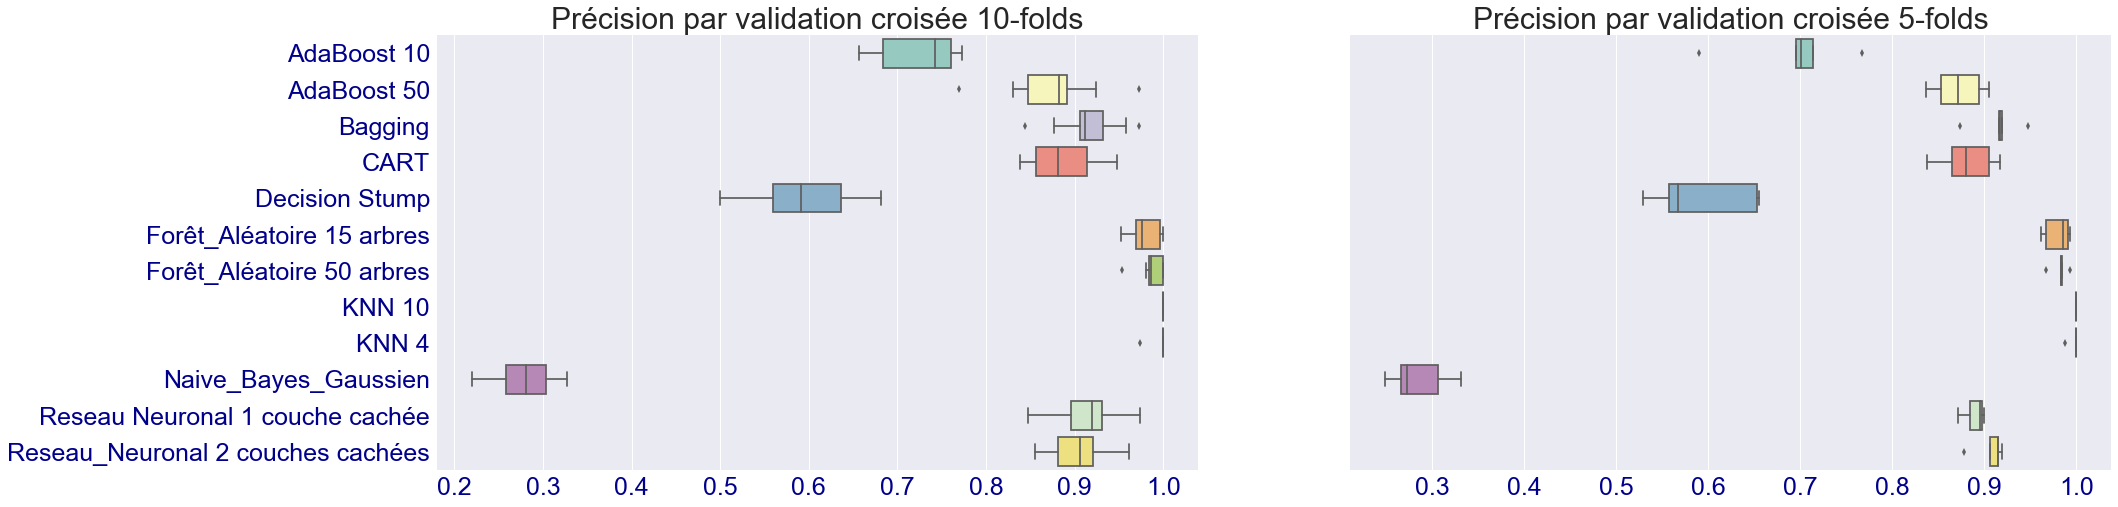

In [51]:
# On convertit cette liste en np array

SMS_avec_num_np = np.array(SMS_avec_num).reshape(-1,1) 

X_500_plus = np.concatenate((X_500, SMS_avec_num_np), axis = 1)

runClassifiers(Liste, X_500_plus, Y_class)

La qualité des résultats est sensiblement la même. En particulier, Naive Bayes admet toujours les mêmes mauvais résultats. Une autre solution, plutôt que de retenir les 500 mots les plus fréquents, serait de sélectioner les 500 les plus pertinents pour l'étiquetage, comme estimé par une méthode de forêt aléatoire.

### Vectorisation Tf-Idf

On considère maintenant une autre vectorisation des SMS, en considérant encore le vocabulaire présent comme ensemble de variables explicatives, mais en pondérant les fréquence de mots par un terme invoquant le nombre de SMS contenant chaque mot (puis en appliqaunt une renormalisation de chaque vecteur obtenu).

estimations par validation croisée 10 fold de Naive_Bayes_Gaussien :
Taux biens classés = 0.769 +/- 0.013
AUC = 0.848 +/- 0.009
Précision = 0.362 +/- 0.032
Précision (5 fold) = 0.359 +/- 0.026
Temps d'exécution = 5.463 secondes


estimations par validation croisée 10 fold de CART :
Taux biens classés = 0.968 +/- 0.006
AUC = 0.930 +/- 0.022
Précision = 0.884 +/- 0.030
Précision (5 fold) = 0.887 +/- 0.019
Temps d'exécution = 65.069 secondes


estimations par validation croisée 10 fold de Decision Stump :
Taux biens classés = 0.887 +/- 0.009
AUC = 0.697 +/- 0.026
Précision = 0.604 +/- 0.059
Précision (5 fold) = 0.600 +/- 0.054
Temps d'exécution = 4.424 secondes


estimations par validation croisée 10 fold de Reseau Neuronal 1 couche cachée :
Taux biens classés = 0.962 +/- 0.007
AUC = 0.976 +/- 0.009
Précision = 0.831 +/- 0.037
Précision (5 fold) = 0.816 +/- 0.015
Temps d'exécution = 99.468 secondes


estimations par validation croisée 10 fold de Reseau_Neuronal 2 couches cachées :
Taux bi

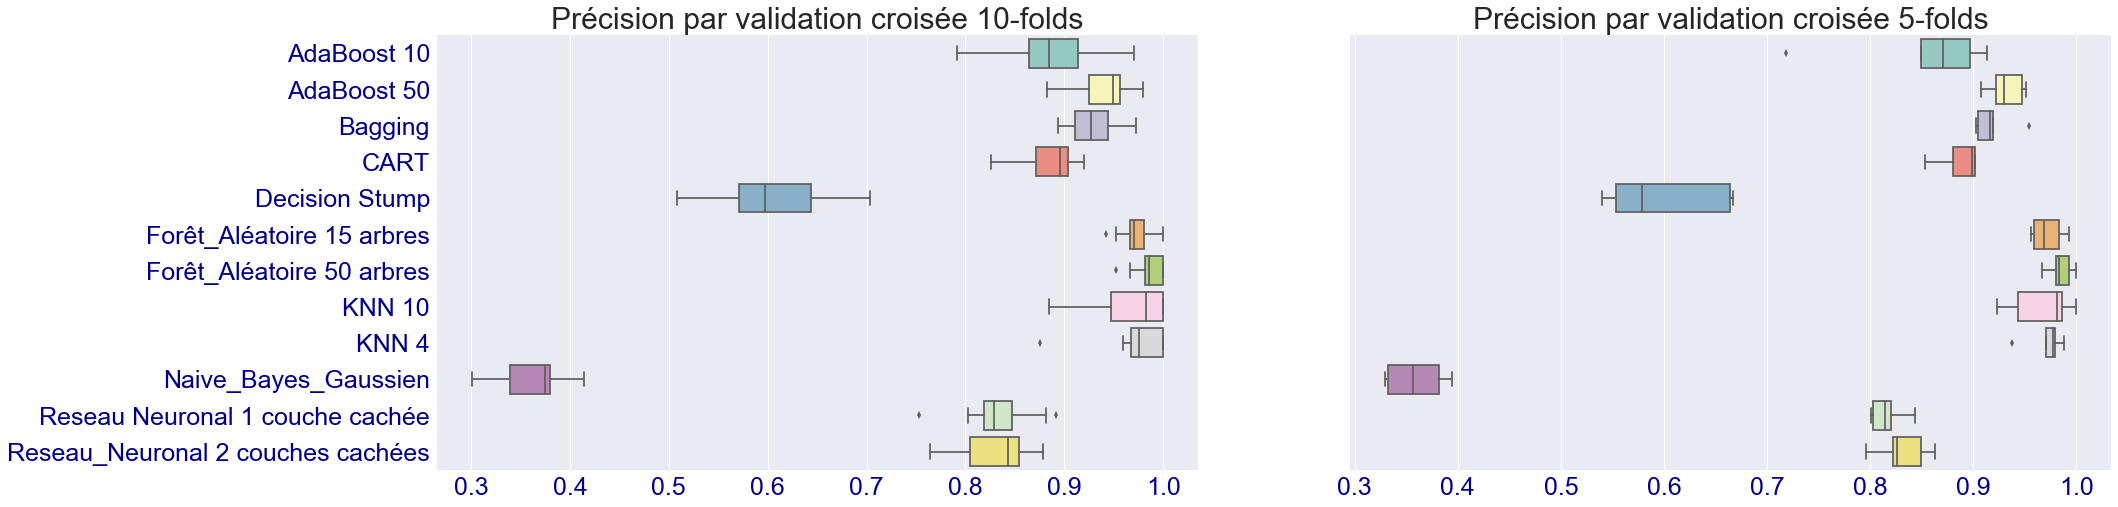

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer_fit = vectorizer.fit_transform(X_corpus)
X_tfidf = vectorizer_fit.toarray()

X_tfidf_500 = np.copy(X_tfidf[:, freq_500[:500]])

runClassifiers(Liste, X_tfidf_500, Y_class)

Les résultats sont variés : Les réseaux de neurones voient leur précision baisser assez nettement, et dans une moindre mesure les K-plus proches voisins aussi, mais celle d'AdaBoost augmente assez clairement.

### Analyse sémantique latente

Mathématiquement, l'analyse sémantique latente consiste à effectuer une ACP sur la matrice X non-centrée, c'est à dire trouver les k valeurs propres les plus élevées de la matrice valeur absolue |x| de la donnée X (c'est à dire, l'unique matrice définie-positive dont le carré vaut X^tX) ainsi que k couples de vecteurs singuliers à gauche / à droite. L'ensemble des k vecteurs singuliers à gauche (multipliés par leur valeur propre associée) sera la matrice des données compressées, tandis que les vecteurs singuliers à droite donnent les coefficients des combinaisons linéaires des variables d'entrée à considérer pour reconstruire ces vecteurs. Voir https://fr.wikipedia.org/wiki/D%C3%A9composition_en_valeurs_singuli%C3%A8res et http://scikit-learn.org/stable/modules/decomposition.html#lsa pour des détails.

On ne garde ici que 10 vecteurs singuliers, en constatant que moins de 30 % de la variabilité des observations est préservée avec ces axes. Néanmoins, nos différents algorithmes admettent des performances honorables :

In [53]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
X_svd_500 = svd.fit_transform(X_500)
print(svd.explained_variance_ratio_)


svd2 = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
X_svd_tfidf_500 = svd2.fit_transform(X_tfidf_500)
print(svd2.explained_variance_ratio_)

[ 0.07301028  0.04018422  0.03295577  0.02365635  0.02287902  0.02145301
  0.01734145  0.01611879  0.01533197  0.01470654]
[ 0.01132531  0.0175261   0.01647498  0.01387192  0.01147887  0.01069485
  0.00988504  0.00913137  0.00852667  0.0082507 ]


estimations par validation croisée 10 fold de Naive_Bayes_Gaussien :
Taux biens classés = 0.931 +/- 0.006
AUC = 0.922 +/- 0.019
Précision = 0.736 +/- 0.044
Précision (5 fold) = 0.736 +/- 0.048
Temps d'exécution = 0.388 secondes


estimations par validation croisée 10 fold de CART :
Taux biens classés = 0.947 +/- 0.007
AUC = 0.892 +/- 0.016
Précision = 0.777 +/- 0.056
Précision (5 fold) = 0.782 +/- 0.037
Temps d'exécution = 2.705 secondes


estimations par validation croisée 10 fold de Decision Stump :
Taux biens classés = 0.866 +/- 0.017
AUC = 0.814 +/- 0.025
Précision = 0.000 +/- 0.000
Précision (5 fold) = 0.000 +/- 0.000
Temps d'exécution = 0.415 secondes


estimations par validation croisée 10 fold de Reseau Neuronal 1 couche cachée :
Taux biens classés = 0.958 +/- 0.008
AUC = 0.961 +/- 0.012
Précision = 0.863 +/- 0.052
Précision (5 fold) = 0.847 +/- 0.025
Temps d'exécution = 35.922 secondes


estimations par validation croisée 10 fold de Reseau_Neuronal 2 couches cachées :
Taux bie

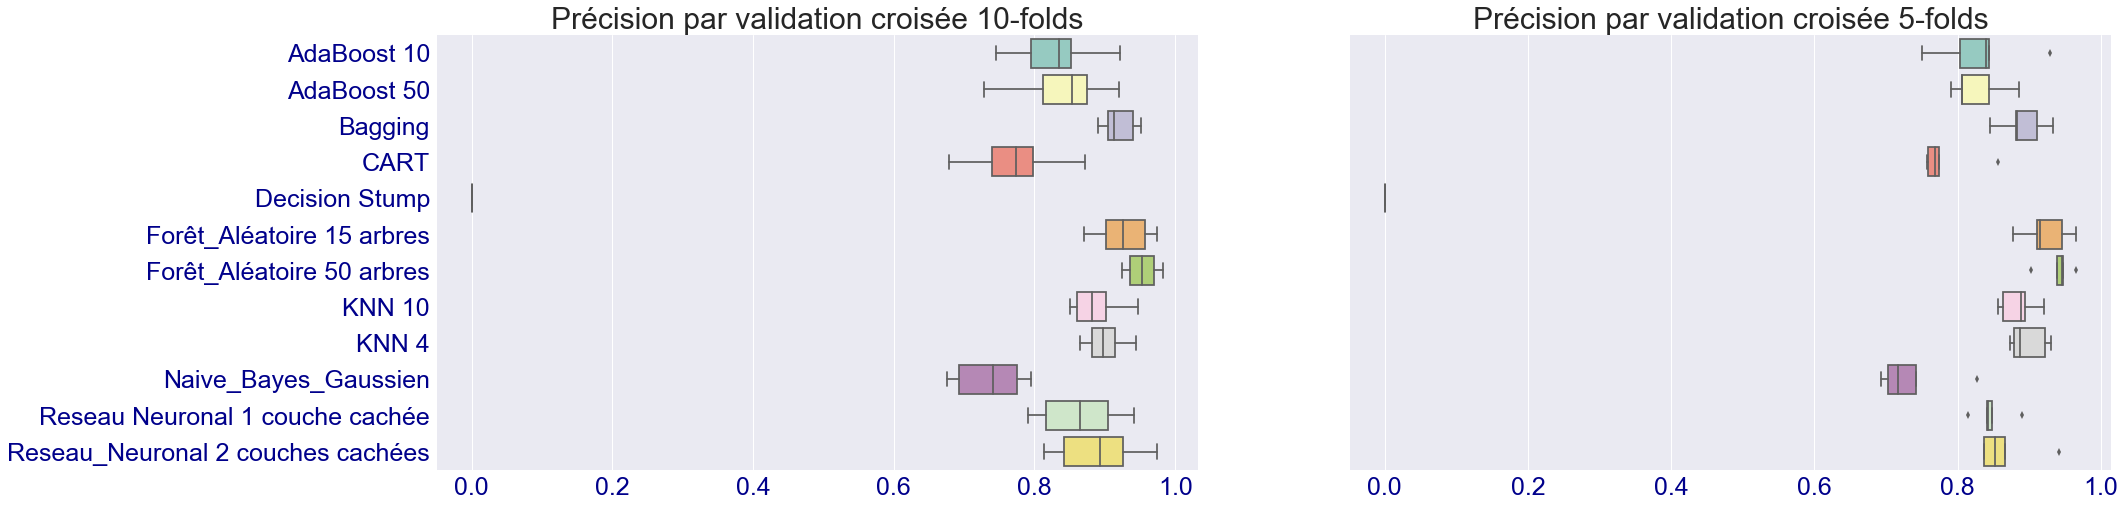

In [54]:
runClassifiers(Liste, X_svd_500, Y_class)

Le Naive Bayes a particulièrement gagné en précision, et à l'inverse la souche de décision prédit trivialement non-spam en toute circonstance, donnant une précision nulle. Dans cette démarche, les forêts aléatoires semblent être les méthodes offrant la meilleure précision, contrairement au cas initial où les K-plus proches voisins semblaient être les méthodes les plus performantes. Dans tous les cas, la décomposition en valeurs singulières tronquée se montre très efficace, puisque elle permet avec 10 attributs d'avoir des performances proches de celles obtenues avec 500 attributs. On constate que la DVS tronquée sur la matrices des SMS vectorisés selon la méthode Tf-Idf est elle aussi très bonne :

estimations par validation croisée 10 fold de Naive_Bayes_Gaussien :
Taux biens classés = 0.922 +/- 0.011
AUC = 0.960 +/- 0.010
Précision = 0.653 +/- 0.047
Précision (5 fold) = 0.653 +/- 0.032
Temps d'exécution = 0.219 secondes


estimations par validation croisée 10 fold de CART :
Taux biens classés = 0.948 +/- 0.012
AUC = 0.889 +/- 0.036
Précision = 0.786 +/- 0.038
Précision (5 fold) = 0.795 +/- 0.035
Temps d'exécution = 2.212 secondes


estimations par validation croisée 10 fold de Decision Stump :
Taux biens classés = 0.886 +/- 0.010
AUC = 0.841 +/- 0.022
Précision = 0.551 +/- 0.047
Précision (5 fold) = 0.554 +/- 0.032
Temps d'exécution = 0.419 secondes


estimations par validation croisée 10 fold de Reseau Neuronal 1 couche cachée :
Taux biens classés = 0.954 +/- 0.004
AUC = 0.974 +/- 0.010
Précision = 0.860 +/- 0.035
Précision (5 fold) = 0.870 +/- 0.022
Temps d'exécution = 28.093 secondes


estimations par validation croisée 10 fold de Reseau_Neuronal 2 couches cachées :
Taux bie

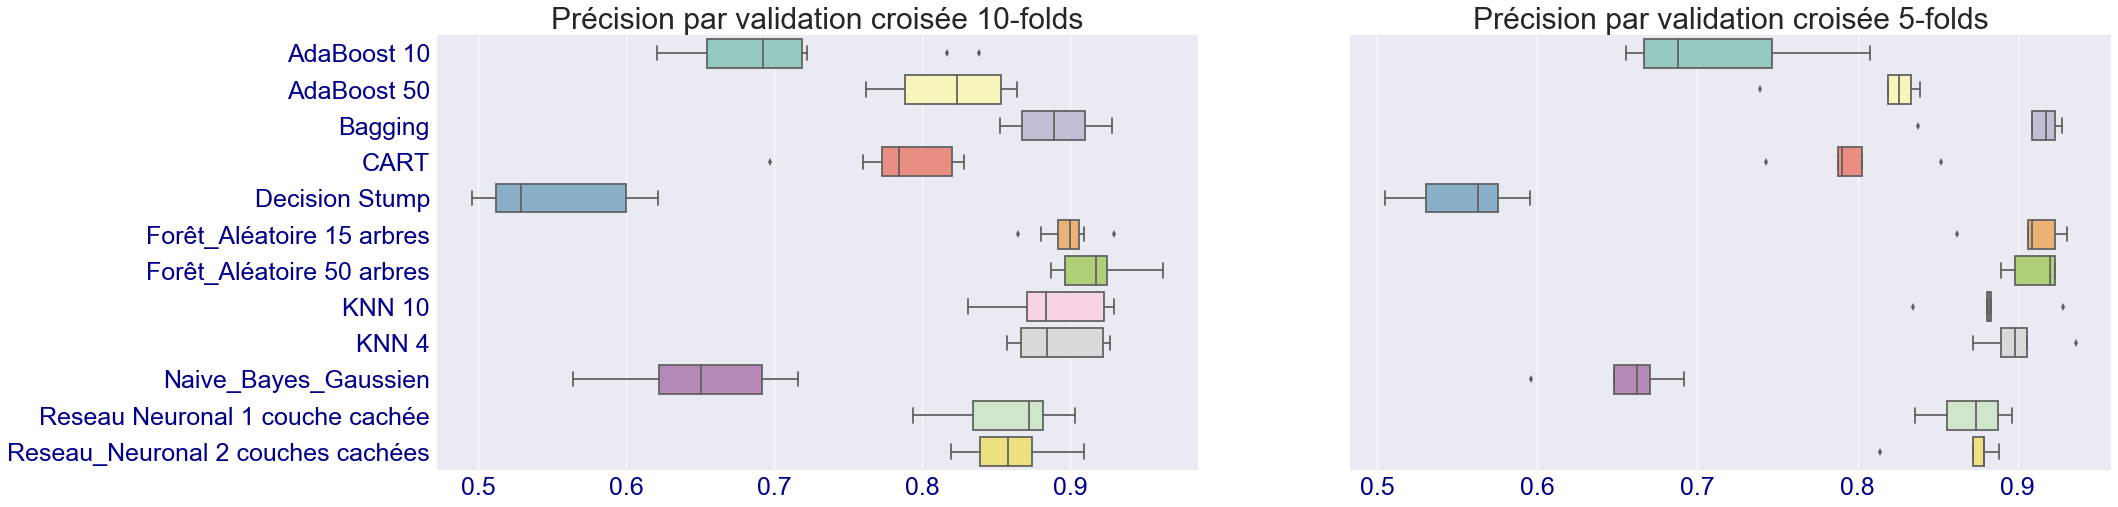

In [55]:
runClassifiers(Liste, X_svd_tfidf_500, Y_class)

# IV. Détection d'anomalies

On effectue de la détection d'anomalies dans un jeu de donnée selon la méthode Isolation Forest, qui évalue le potentiel d'anomalie d'une observation en comptant combien d'étapes sont nécessaires, lorsqu'on effectue plusieurs arbres de décisions par sélection aléatoire de variable et valeur de coupe, pour isoler l'observation du reste de la donnée. Plus cette isolation est rapide, plus l'observation est potentiellement aberrante. Cette détection d'anomalies est donc un problème de classification binaire non-supervisée.

### Détection d'anomalies sur la tête de Mickey

On commence avec un jeu de données en tête de Mickey. On charge la donnée, affiche la tête et queue de la donnée et visualise ensuite celle-ci sur un plan :


In [56]:
from sklearn.ensemble import IsolationForest
import pandas as pd

mouse = pd.read_csv("mouse.txt", header = None, sep = " ", names = ["X1", "X2"])
print(mouse.head())
print(mouse.tail())
mouse.isnull().any() # pas de données manquantes

         X1        X2
0  0.456601  0.432806
1  0.611378  0.528625
2  0.450299  0.711606
3  0.639015  0.460744
4  0.628957  0.323470
           X1        X2
495  0.151506  0.876586
496  0.860308  0.633833
497  0.862083  0.591805
498  0.916030  0.523391
499  0.427325  0.833767


X1    False
X2    False
dtype: bool

In [57]:
# la donnée prend des valeurs comprises entre 0 et 1 dans les deux directions
print(mouse["X1"].min(), mouse["X1"].max(), mouse["X2"].min(), mouse["X2"].max())

0.0405549277448 0.916029808382 0.138940388148 0.89702766075


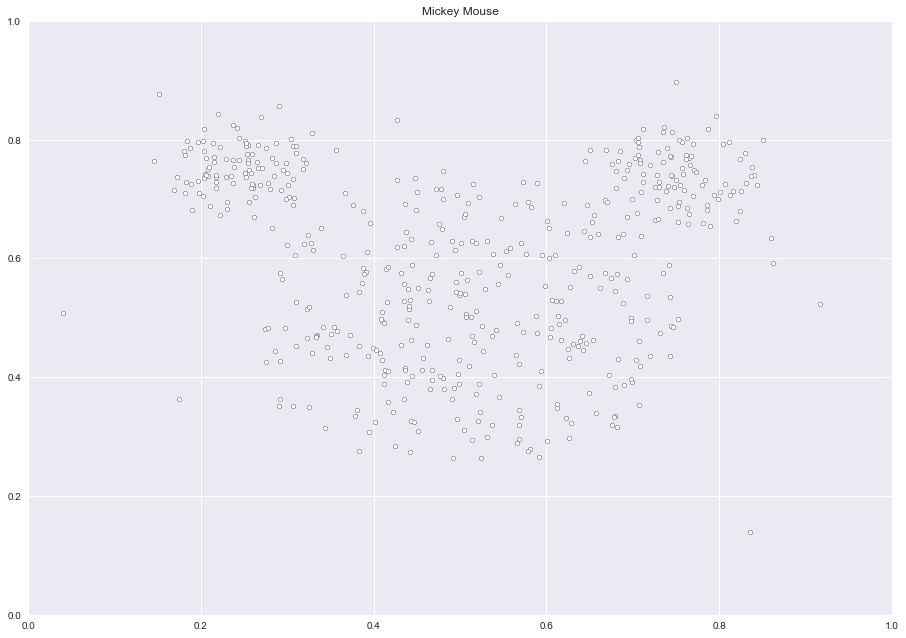

In [58]:
Mickey = mouse.ix[:, :].values


plt.title("Mickey Mouse")
plt.scatter(Mickey[: ,0] , Mickey[:, 1], c='white', s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((0, 1))
plt.ylim((0, 1))

plt.subplots_adjust(bottom=0, top=1.5, wspace=0.2,left=0, right=1.5)
plt.show()

Certains points apparaissent clairement comme aberrants. On implémente alors la détection de valeurs aberrantes par l'Isolation Forest, avec 50 arbres (on a également testé avec 100 et 200 arbres, le résultat est sensiblement le même) :

In [59]:
ilf = IsolationForest(n_estimators=50, n_jobs=-1, verbose=2)
ilf.fit(mouse)
pred = ilf.predict(mouse)

[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.4s finished


On visualise alors la classification des observations normales/aberrantes, avec une troisième couleur pour les vraies valeurs aberrantes (voir http://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest ) :

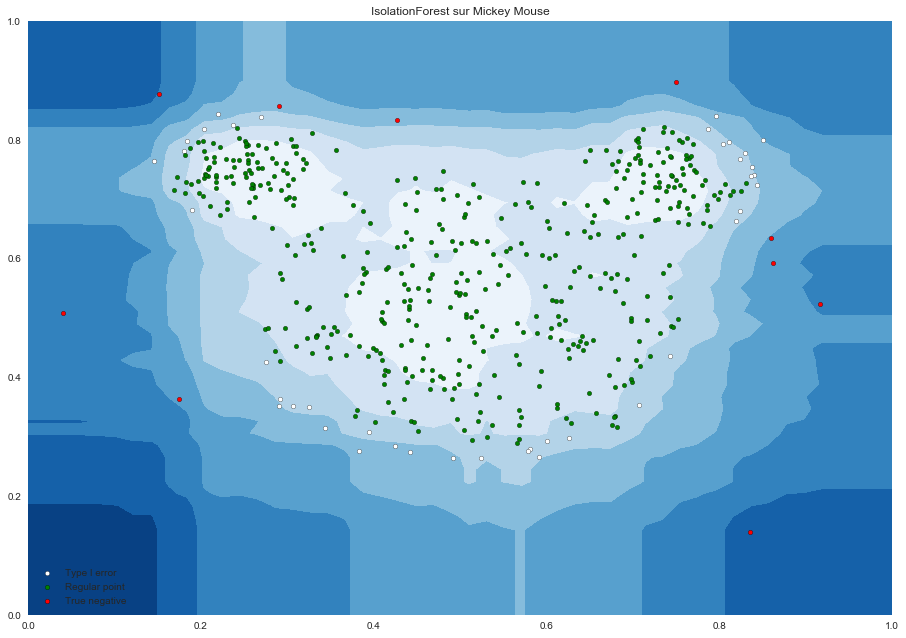

In [60]:
xx, yy = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
Z = ilf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest sur Mickey Mouse")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(mouse[:-10].loc[pred[:-10] == -1]["X1"] , mouse[0:-10].loc[pred[0:-10] == -1]["X2"], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(mouse[:-10].loc[pred[:-10] == 1]["X1"], mouse[0:-10].loc[pred[0:-10] == 1]["X2"], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(mouse.loc[490:, "X1"], mouse.loc[490:, "X2"], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.legend([b1, b2, c],
           ["Type I error",
            "Regular point", "True negative"],
           loc="lower left")
plt.subplots_adjust(bottom=0, top=1.5, wspace=0.2,left=0, right=1.5)
plt.show()

### Transactions banquaires frauduleuses

On commence par charger la donnée :

In [61]:
creditcard = pd.read_csv("creditcard.csv", header = 0, usecols = range(1, 31))
creditcard.head()

V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...         V21       V22       V23  \
0  0.098698  0.363787  0.090794  ...   -0.018307  0.277838 -0.110474   
1  0.085102 -0.255425 -0.166974  ...   -0.225775 -0.638672  0.101288   
2  0.247676 -1.514654  0.207643  ...    0.247998  0.771679  0.909412   
3  0.377436 -1.387024 -0.054952  ...   -0.108300  0.005274 -0.190321   
4 -0.270533  0.817739  0.753074  ...   -0.009431  0.798278 -0.137458   

        V24       V25       V26       V27       V28  Amount  Class  
0  0.066928  0.128539 -0.189115  0.133558 -0.021053  149.62      0  
1 -0.339846  0.167170  0.125895 -0.008983  0.014724    2.69      0  
2 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752  378.66      0  
3 -1.175575  0.647376 -0.221929  0.062723  0.061458  123.50      0  
4  0.141267 -0.206010  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 30 columns]

On fait une sélection en ne conservant que 5000 observations correspondant à des transactions normales et les 492 fraudes :

In [62]:
creditcard["Class"]

#print(creditcard.isnull().any()) # pas de valeur manquante

X_bad = creditcard.loc[creditcard["Class"] == 1, creditcard.columns != "Class"]
#print(X_bad.head())
print(X_bad.shape)

X_good_rand = creditcard.loc[creditcard["Class"] == 0, creditcard.columns != "Class"].sample(n=5000)
#print(X_good_rand.head())
print(X_good_rand.shape)

X_clean = X_bad.append(X_good_rand)
#print(X_clean.head())
print(X_clean.shape)

(492, 29)
(5000, 29)
(5492, 29)


On reconstitue le vecteur de classes pour les observations gardées, avec 1 pour transaction frauduleuse et 0 sinon :

In [63]:
Y = []
for i in range(492) :
    Y.append(1)
for i in range(5000) :
    Y.append(0)

Puis on lance la détection d'anomalies avec une méthode de forêt isolante à 100 arbres :

In [64]:
ilf_creditcard = IsolationForest(n_estimators=100, n_jobs=-1, verbose=2)
ilf_creditcard.fit(X_clean)
pred_creditcard = ilf_creditcard.predict(X_clean)

[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.6s finished


On convertit la prédiction de classes vers des valeurs 0 - 1, où 1 désigne une transaction frauduleuse :

In [65]:
pred_creditcard[:492][pred_creditcard[:492] == -1].sum()

pred_creditcard[pred_creditcard == 1] = 0 # à faire tourner une seule fois !
pred_creditcard[pred_creditcard == -1] = 1 # à faire tourner une seule fois !

On affiche la table de confusion :

In [66]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y, pred_creditcard)

array([[4802,  198],
       [ 140,  352]])

Parmis les 492 transactions frauduleux, seulement 365 sont détectées et 127 sont considérées comme des transactions normales par le système. Le rappel de cette classification est donc de l'ordre de 0.75, soit une valeur faible étant donnée la nature du problème.

### Spams dans les SMS

On sélectionne parmis nos SMS 20 spams et 2500 non-spam :

In [67]:
n = 0
Spams_20 = []

for i, classe in enumerate(Y_class) :
    if n < 20 and classe == 1 :
        Spams_20.append(i)
        n += 1

print(Spams_20)


X_spams_20 = np.copy(X_svd_tfidf_500[ Spams_20 , :])


# On a 4825 non-spam parmi la collection de SMS
Non_Spams = []
for i, el in enumerate(Y_class) :
    if el == 0 :
        Non_Spams.append(i)


print(len(Y_class) - len(Non_Spams))

# on en prend 2500
Non_Spams = Non_Spams[ : 2500]

print(Non_Spams[:100])
X_non_spam_2500 = X_svd_tfidf_500[ Non_Spams , :]
print(X_non_spam_2500.shape)


X_isolation = np.concatenate((X_spams_20 , X_non_spam_2500), axis = 0 )
print(X_isolation.shape)

real_sms = []
for i in range(20) :
    real_sms.append(1)
for i in range(2500) :
    real_sms.append(0)
    
 

[2, 5, 8, 9, 11, 12, 15, 19, 34, 42, 54, 56, 65, 67, 68, 93, 95, 114, 117, 120]
747
[0, 1, 3, 4, 6, 7, 10, 13, 14, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 57, 58, 59, 60, 61, 62, 63, 64, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 118]
(2500, 10)
(2520, 10)


In [68]:
ilf_sms = IsolationForest(n_estimators=50, n_jobs=-1, verbose=2)
ilf_sms.fit(X_isolation)
pred_sms = ilf_sms.predict(X_isolation)

[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.8s finished


In [69]:
pred_sms[pred_sms == 1] = 0 # run only once !
pred_sms[pred_sms == -1] = 1 #run only once !


confusion_matrix(real_sms, pred_sms)

array([[2250,  250],
       [  18,    2]])

Nous avons 250 mails considérés comme spam alors qu'ils ne le sont pas, et parmi les 20 spams, 18 sont considérés comme normaux. La détection d'anomalie est donc de piètre qualité ici. On compare ce résultat avec une détection d'anomalie sur la donnée sans application de la décomposition en valeurs singulière tronquée :

In [70]:
svd3 = TruncatedSVD(n_components=30, n_iter=7, random_state=42)
Z = svd3.fit_transform(X_tfidf_500)

Z_spams_20 = np.copy(X_500[ Spams_20 , :])

Z_non_spam_2500 = X_500[ Non_Spams , :]

Z_isolation = np.concatenate((Z_spams_20 , Z_non_spam_2500), axis = 0 )

In [71]:
ilf_sms = IsolationForest(n_estimators=100, n_jobs=-1, verbose=2)
ilf_sms.fit(Z_isolation)
pred_sms = ilf_sms.predict(Z_isolation)

[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.9s finished


In [72]:
pred_sms[pred_sms == 1] = 0 # run only once !
pred_sms[pred_sms == -1] = 1 #run only once !


confusion_matrix(real_sms, pred_sms)

array([[2251,  249],
       [  17,    3]])

Le résultat est à peine mieux. On gardera en tête que, des 5000 mots présents dans le corpus, on en a conservé que les 500 les plus fréquents, ce qui peut être une vraie limite à la détection d'anomalie.